In [320]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
from tqdm import tqdm
import fit_time_dep_fluxes as fit_flux
import os

import matplotlib
#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)


In [321]:
plotpath = './figures/'
if not os.path.isdir(plotpath):
    os.makedirs(plotpath)


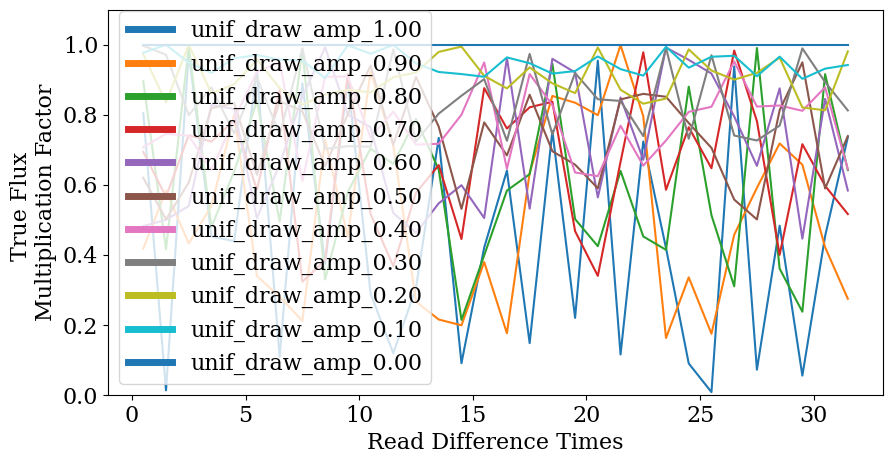

In [322]:
#generate some synthetic data

np.random.seed(101)

n_reads = 33
n_pixels = 100

#set the read noise in each pixel
# read_errs = ((np.random.rand(n_pixels)-0.5)*2)*5 + 28
read_errs = np.ones(n_pixels) * 19

true_flux_levels = np.logspace(-1,3,11)[::-1]
true_flux_levels = np.logspace(-1,3,5)[::-1]
true_flux_levels = np.array([1000,100,10,1])
true_flux_levels = np.array([1000,10])
true_flux_levels = np.array([1000,100,10])
true_flux_levels = np.array([1000])
# true_flux_levels = np.array([100])

#hard-to-measure low fluxes to be used with b vectors
test_low_fluxes = ((np.random.rand(n_pixels)-0.5)*2)*2 + 5

#range of fluxes to extract
n_test_range_pixels = 21
test_range_fluxes = np.logspace(1,3,n_test_range_pixels)

# true_flux_levels = np.array([true_flux_levels[0]])
# true_flux_levels = true_flux_levels[:3]

true_b_dict = {
    'ones':np.ones(n_reads-1),
    'constant change':np.linspace(0.25,1.0,n_reads-1),
    'uniform draw':1.0 - (np.random.rand(n_reads-1))*0.5,
}
true_b_dict['drop to half'] = np.ones(n_reads-1)*0.9
true_b_dict['drop to half'][n_reads//2:] *= 0.5

true_b_dict = {}
for b_amp in np.linspace(0,1.0,11)[::-1]:
    true_b_dict['unif_draw_amp_%.2f'%b_amp] = 1.0 - (np.random.rand(n_reads-1))*b_amp

read_times = np.arange(n_reads)
read_diff_times = 0.5*(read_times[1:]+read_times[:-1])

plt.figure(figsize=(10,5))
for key in true_b_dict:
    plt.plot(read_diff_times,true_b_dict[key],label=key)
# leg = plt.legend(loc=6,bbox_to_anchor=(1.01,0.5))
leg = plt.legend(loc='best')
for line in leg.get_lines():
    line.set_linewidth(5.0)
plt.ylim(0,1.1)
plt.ylabel('True Flux \nMultiplication Factor')
plt.xlabel('Read Difference Times')
plt.show()


In [4]:

#number of times to redraw the data using the same true_b_vect, true_fluxes, read_errs
n_sim = 1000
# n_sim = 100

b_amp_results_dict = {}

# np.random.seed(101)

b_ind = 0
for key in true_b_dict:
    b_ind += 1
    b_amp_results_dict[key] = {}
    true_b_vect = true_b_dict[key]
    
    # no_b_flux_scaling = 1/np.mean(true_b_vect)
    for flux_level_ind,flux_level in enumerate(true_flux_levels):
        
        # true_fluxes = true_flux_dict[flux_level]
        
        true_fluxes = np.ones(n_pixels)*flux_level
        # true_fluxes = flux_level + 0.1*(2*(np.random.rand(n_pixels)-0.5))*flux_level
    
        print(f'Fitting {n_sim} simulations of {round(flux_level,3)} flux level data with b_vect = {key}:')
        
        for s_ind,_ in enumerate(tqdm(np.arange(n_sim),total=n_sim)):

            true_b_vect = true_b_dict[key]
            b_amp = float(key.split('_')[-1])
            true_b_vect = 1.0 - (np.random.rand(n_reads-1))*b_amp
        
            # np.random.seed((n_sim)*(flux_level_ind+1)*(b_ind+1)+s_ind)
        
            #draw new data
            obs_fluxes = fit_flux.generate_data(read_errs,true_fluxes,true_b_vect)
            obs_fluxes_errs = np.sqrt(np.power(read_errs,2)+np.maximum(true_fluxes,0))
            obs_flux_diffs = np.diff(obs_fluxes,axis=1)
            # obs_flux_diff_errs = np.sqrt((read_err*2)**2+np.maximum(true_fluxes[:,1:],0))
            obs_flux_diff_errs = np.sqrt(np.power(read_errs*2,2)[:,None]+np.maximum(obs_flux_diffs,0))

            min_b_val = 1e-10
            min_f_val = 1e-10
            max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
                    f_max_means_given_b,f_max_ivars_given_b,\
                    comb_param_means,comb_param_Vinv,comb_param_V = fit_flux.measure_time_dep_fluxes_LINEAR(obs_fluxes,read_errs,
                                                                   n_max_repeat=20,b_vect_change_tol=1e-10,
                                                                   min_b_val=min_b_val,min_f_val=min_f_val,
                                                                   rescale=True,true_b_vect=true_b_vect,
                                                                   true_fluxes=true_fluxes,random_max_b=True)
        
            
            non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
            non_max_inds[max_b_ind] = False
            non_max_inds = np.where(non_max_inds)[0]
            
            b_vect_errs = np.sqrt(np.diag(b_vect_V))
            f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

            f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                           n_repeat=2,b_vect=None)
            
            #remember to scale the non-b-fit fluxes as well
            #to be fair for comparison
    
            mult_var = 1/np.sum(np.power(f_means_no_b,2)*f_ivars_no_b)
            mult_mean = mult_var * np.sum(f_means_no_b*true_fluxes*f_ivars_no_b)
    
            f_means_no_b *= mult_mean
            f_ivars_no_b /= mult_mean**2

            f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                               n_repeat=2,
                                                                               b_vect=np.maximum(b_vect_mean,min_b_val))
            
                
            test_low_obs_fluxes = fit_flux.generate_data(read_errs,test_low_fluxes,true_b_vect)
            
            low_flux_f_means_no_b,\
                    low_flux_f_ivars_no_b,\
                    low_flux_chi2s_data_no_b = fit_flux.fit_fluxes_optimal(test_low_obs_fluxes,read_errs,
                                                                           n_repeat=2,b_vect=None)
            low_flux_f_means_with_b,\
                    low_flux_f_ivars_with_b,\
                    low_flux_chi2s_data_with_b = fit_flux.fit_fluxes_optimal(test_low_obs_fluxes,read_errs,
                                                                             n_repeat=2,b_vect=b_vect_mean)
            
            if s_ind == 0:
                max_b_inds = np.zeros(n_sim).astype(int)
                b_vect_means = np.zeros((n_sim,*b_vect_mean.shape))
                b_vect_Vinvs = np.zeros((n_sim,*b_vect_Vinv.shape))
                b_vect_Vs = np.zeros((n_sim,*b_vect_V.shape))
                f_max_means_given_bs = np.zeros((n_sim,*f_max_means_given_b.shape))
                f_max_ivars_given_bs = np.zeros((n_sim,*f_max_ivars_given_b.shape))
                all_comb_param_means = np.zeros((n_sim,*comb_param_means.shape))
                all_comb_param_Vinvs = np.zeros((n_sim,*comb_param_Vinv.shape))
                all_comb_param_Vs = np.zeros((n_sim,*comb_param_V.shape))
                all_non_max_inds = np.zeros((n_sim,*non_max_inds.shape))
                all_b_vect_errs = np.zeros((n_sim,*b_vect_errs.shape))
                all_f_max_errs_given_bs = np.zeros((n_sim,*f_max_errs_given_b.shape))    
                
                all_f_max_zscores = np.zeros((n_sim,n_pixels))
                all_f_max_chi2s = np.zeros((n_sim))
                all_f_given_b_zscores = np.zeros((n_sim,n_pixels))
                all_f_given_b_chi2s = np.zeros((n_sim))
                
                all_b_vect_zscores = np.zeros((n_sim,n_reads-2))
                all_b_vect_chi2s = np.zeros((n_sim))
        
                all_comb_param_zscores = np.zeros((n_sim,len(comb_param_means)))
                all_comb_param_chi2s = np.zeros((n_sim))
    
                all_chi2s_data_no_bs = np.zeros((n_sim,*chi2s_data_no_b.shape))
                all_chi2s_data_with_bs = np.zeros((n_sim,*chi2s_data_with_b.shape))
                all_low_flux_chi2s_data_no_bs = np.zeros((n_sim,*low_flux_chi2s_data_no_b.shape))
                all_low_flux_chi2s_data_with_bs = np.zeros((n_sim,*low_flux_chi2s_data_with_b.shape))

                n_repeat_test_range = 100
                all_f_given_b_chi2s_with_bs = np.zeros((n_sim,n_repeat_test_range))
                all_f_given_b_chi2s_no_bs = np.zeros((n_sim,n_repeat_test_range))
                all_f_given_b_zscores_with_bs = np.zeros((n_sim,n_repeat_test_range,n_test_range_pixels))
                all_f_given_b_zscores_no_bs = np.zeros((n_sim,n_repeat_test_range,n_test_range_pixels))
                all_f_given_b_errs_with_bs = np.zeros((n_sim,n_repeat_test_range,n_test_range_pixels))
                all_f_given_b_errs_no_bs = np.zeros((n_sim,n_repeat_test_range,n_test_range_pixels))

                all_f_given_b_zscores_no_bs_summaries = np.zeros((n_sim,3))
                all_f_given_b_zscores_with_bs_summaries = np.zeros((n_sim,3))
                all_f_given_b_errs_no_bs_summaries = np.zeros((n_sim,3))
                all_f_given_b_errs_with_bs_summaries = np.zeros((n_sim,3))
        
            #save outputs, compare to truth, save summary statistics (like z-scores and chi2s)
            true_param_means = np.zeros_like(comb_param_means)
            true_param_means[:n_pixels] = true_fluxes
            true_param_means[n_pixels:] = true_b_vect[non_max_inds]
        
            max_b_inds[s_ind] = max_b_ind
            b_vect_means[s_ind] = b_vect_mean
            b_vect_Vinvs[s_ind] = b_vect_Vinv
            b_vect_Vs[s_ind] = b_vect_V
            f_max_means_given_bs[s_ind] = f_max_means_given_b
            f_max_ivars_given_bs[s_ind] = f_max_ivars_given_b
            all_comb_param_means[s_ind] = comb_param_means
            all_comb_param_Vinvs[s_ind] = comb_param_Vinv
            all_comb_param_Vs[s_ind] = comb_param_V
            all_non_max_inds[s_ind] = non_max_inds
            all_b_vect_errs[s_ind] = b_vect_errs
            all_f_max_errs_given_bs[s_ind] = f_max_errs_given_b
        
            all_b_vect_zscores[s_ind] = (b_vect_mean[non_max_inds]-true_b_vect[non_max_inds])/b_vect_errs[non_max_inds]
            all_f_max_zscores[s_ind] = (comb_param_means[:n_pixels]-true_fluxes)/np.sqrt(np.diag(comb_param_V)[:n_pixels])
            all_f_given_b_zscores[s_ind] = (f_max_means_given_b-true_fluxes)*np.sqrt(f_max_ivars_given_b)
            all_f_given_b_chi2s[s_ind] = np.sum(np.power(all_f_given_b_zscores[s_ind],2))
            all_comb_param_zscores[s_ind] = (comb_param_means-true_param_means)/np.sqrt(np.diag(comb_param_V))
            
            diff = comb_param_means-true_param_means
            all_comb_param_chi2s[s_ind] = np.dot(diff,np.dot(comb_param_Vinv,diff))
            diff = (comb_param_means-true_param_means)[n_pixels:]
            all_b_vect_chi2s[s_ind] = np.dot(diff,np.dot(comb_param_Vinv[n_pixels:,n_pixels:],diff))
            diff = (comb_param_means-true_param_means)[:n_pixels]
            all_f_max_chi2s[s_ind] = np.dot(diff,np.dot(comb_param_Vinv[:n_pixels,:n_pixels],diff))
    
            all_chi2s_data_no_bs[s_ind] = chi2s_data_no_b
            all_chi2s_data_with_bs[s_ind] = chi2s_data_with_b
            all_low_flux_chi2s_data_no_bs[s_ind] = low_flux_chi2s_data_no_b
            all_low_flux_chi2s_data_with_bs[s_ind] = low_flux_chi2s_data_with_b


            n_test_pixels = 100
            true_high_fluxes = np.ones(n_test_pixels)*test_range_fluxes.max()

            for test_ind in range(n_repeat_test_range):
                test_high_obs_fluxes = fit_flux.generate_data(np.nanmedian(read_errs)*np.ones(n_test_pixels),
                                                             true_high_fluxes,true_b_vect)
                f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(test_high_obs_fluxes,
                                                              np.nanmedian(read_errs)*np.ones(n_test_pixels),
                                                                                        n_repeat=2,b_vect=None)  
                mult_var = 1/np.sum(np.power(f_means_no_b,2)*f_ivars_no_b)
                mult_mean = mult_var * np.sum(f_means_no_b*true_high_fluxes*f_ivars_no_b)
                mult_mean = mult_mean + np.random.randn()*np.sqrt(mult_var)
                
                test_new_obs_fluxes = fit_flux.generate_data(np.nanmedian(read_errs)*np.ones(n_test_range_pixels),
                                                             test_range_fluxes,true_b_vect)
                
                f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(test_new_obs_fluxes,
                                                              np.nanmedian(read_errs)*np.ones(n_test_range_pixels),
                                                               n_repeat=2,b_vect=None)            
                f_means_no_b *= mult_mean
                f_ivars_no_b /= mult_mean**2

                # curr_mult_mean = mult_mean + np.random.randn()*np.sqrt(mult_var)
                # f_means_no_b *= curr_mult_mean
                # f_ivars_no_b /= curr_mult_mean**2

                # mult_var = 1/np.sum(np.power(f_means_no_b,2)*f_ivars_no_b)
                # mult_mean = mult_var * np.sum(f_means_no_b*test_range_fluxes*f_ivars_no_b)
                # mult_mean = mult_mean + np.random.randn()*np.sqrt(mult_var)
        
                # f_means_no_b *= mult_mean
                # f_ivars_no_b /= mult_mean**2

                f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(test_high_obs_fluxes,
                                                                                np.nanmedian(read_errs)*np.ones(n_test_pixels),
                                                                                   n_repeat=2,
                                                                                   b_vect=np.maximum(b_vect_mean,min_b_val))
                mult_var = 1/np.sum(np.power(f_means_with_b,2)*f_ivars_with_b)
                mult_mean = mult_var * np.sum(f_means_with_b*true_high_fluxes*f_ivars_with_b)
                mult_mean = mult_mean + np.random.randn()*np.sqrt(mult_var)
                
                f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(test_new_obs_fluxes,
                                                                                np.nanmedian(read_errs)*np.ones(n_test_range_pixels),
                                                                                   n_repeat=2,
                                                                                   b_vect=np.maximum(b_vect_mean,min_b_val))

                f_means_with_b *= mult_mean
                f_ivars_with_b /= mult_mean**2

                # all_f_given_b_zscores_with_bs[s_ind] = (f_means_with_b-true_fluxes)*np.sqrt(f_ivars_with_b)
                all_f_given_b_zscores_with_bs[s_ind,test_ind] = (f_means_with_b-test_range_fluxes)*np.sqrt(f_ivars_with_b)
                all_f_given_b_chi2s_with_bs[s_ind,test_ind] = np.sum(np.power(all_f_given_b_zscores_with_bs[s_ind,test_ind],2))
                all_f_given_b_errs_with_bs[s_ind,test_ind] = np.power(f_ivars_with_b,-0.5)
            
                # all_f_given_b_zscores_no_bs[s_ind] = (f_means_no_b-true_fluxes)*np.sqrt(f_ivars_no_b)
                all_f_given_b_zscores_no_bs[s_ind,test_ind] = (f_means_no_b-test_range_fluxes)*np.sqrt(f_ivars_no_b)
                all_f_given_b_chi2s_no_bs[s_ind,test_ind] = np.sum(np.power(all_f_given_b_zscores_no_bs[s_ind,test_ind],2))
                all_f_given_b_errs_no_bs[s_ind,test_ind] = np.power(f_ivars_no_b,-0.5)
    
            # # all_f_given_b_zscores_with_bs[s_ind] = (f_means_with_b-true_fluxes)*np.sqrt(f_ivars_with_b)
            # all_f_given_b_zscores_with_bs[s_ind] = (f_means_with_b-test_range_fluxes)*np.sqrt(f_ivars_with_b)
            # all_f_given_b_chi2s_with_bs[s_ind] = np.sum(np.power(all_f_given_b_zscores_with_bs[s_ind],2))
            # all_f_given_b_errs_with_bs[s_ind] = np.power(f_ivars_with_b,-0.5)
        
            # # all_f_given_b_zscores_no_bs[s_ind] = (f_means_no_b-true_fluxes)*np.sqrt(f_ivars_no_b)
            # all_f_given_b_zscores_no_bs[s_ind] = (f_means_no_b-test_range_fluxes)*np.sqrt(f_ivars_no_b)
            # all_f_given_b_chi2s_no_bs[s_ind] = np.sum(np.power(all_f_given_b_zscores_no_bs[s_ind],2))
            # all_f_given_b_errs_no_bs[s_ind] = np.power(f_ivars_no_b,-0.5)
    
            percentiles = [stats.norm.sf(1)*100,50,stats.norm.sf(-1)*100]
            all_f_given_b_zscores_no_bs_summaries[s_ind] = np.nanpercentile(all_f_given_b_zscores_no_bs[s_ind],percentiles)
            all_f_given_b_zscores_with_bs_summaries[s_ind] = np.nanpercentile(all_f_given_b_zscores_with_bs[s_ind],percentiles)
            all_f_given_b_errs_no_bs_summaries[s_ind] = np.nanpercentile(all_f_given_b_errs_no_bs[s_ind],percentiles)
            all_f_given_b_errs_with_bs_summaries[s_ind] = np.nanpercentile(all_f_given_b_errs_with_bs[s_ind],percentiles)
        
        b_amp_results_dict[key][flux_level_ind] = {
            'all_b_vect_zscores':all_b_vect_zscores,
            'all_f_max_zscores':all_b_vect_zscores,
            'all_f_given_b_zscores':all_f_given_b_zscores,
            'all_f_given_b_chi2s':all_f_given_b_chi2s,
            'all_f_given_b_zscores_with_bs':all_f_given_b_zscores_with_bs,
            'all_f_given_b_chi2s_with_bs':all_f_given_b_chi2s_with_bs,
            'all_f_given_b_zscores_no_bs':all_f_given_b_zscores_no_bs,
            'all_f_given_b_chi2s_no_bs':all_f_given_b_chi2s_no_bs,
            'all_comb_param_zscores':all_comb_param_zscores,
            'all_comb_param_chi2s':all_comb_param_chi2s,
            'all_b_vect_chi2s':all_b_vect_chi2s,
            'all_f_max_chi2s':all_f_max_chi2s,
            'all_chi2s_data_no_bs':all_chi2s_data_no_bs,
            'all_chi2s_data_with_bs':all_chi2s_data_with_bs,
            'all_low_flux_chi2s_data_no_bs':all_low_flux_chi2s_data_no_bs,
            'all_low_flux_chi2s_data_with_bs':all_low_flux_chi2s_data_with_bs,
            'all_f_given_b_zscores_no_bs_summaries':all_f_given_b_zscores_no_bs_summaries,
            'all_f_given_b_zscores_with_bs_summaries':all_f_given_b_zscores_with_bs_summaries,
            'all_f_given_b_errs_no_bs_summaries':all_f_given_b_errs_no_bs_summaries,
            'all_f_given_b_errs_with_bs_summaries':all_f_given_b_errs_with_bs_summaries,
            'all_f_given_b_errs_with_bs':all_f_given_b_errs_with_bs,
            'all_f_given_b_errs_no_bs':all_f_given_b_errs_no_bs,
        }
        
        print('Done')


Fitting 1000 simulations of 1000 flux level data with b_vect = unif_draw_amp_1.00:


100%|███████████████████████████████████████| 1000/1000 [42:34<00:00,  2.55s/it]


Done
Fitting 1000 simulations of 1000 flux level data with b_vect = unif_draw_amp_0.90:


100%|███████████████████████████████████████| 1000/1000 [42:23<00:00,  2.54s/it]


Done
Fitting 1000 simulations of 1000 flux level data with b_vect = unif_draw_amp_0.80:


100%|███████████████████████████████████████| 1000/1000 [42:17<00:00,  2.54s/it]


Done
Fitting 1000 simulations of 1000 flux level data with b_vect = unif_draw_amp_0.70:


100%|███████████████████████████████████████| 1000/1000 [43:24<00:00,  2.60s/it]


Done
Fitting 1000 simulations of 1000 flux level data with b_vect = unif_draw_amp_0.60:


100%|█████████████████████████████████████| 1000/1000 [4:21:03<00:00, 15.66s/it]


Done
Fitting 1000 simulations of 1000 flux level data with b_vect = unif_draw_amp_0.50:


100%|███████████████████████████████████████| 1000/1000 [41:36<00:00,  2.50s/it]


Done
Fitting 1000 simulations of 1000 flux level data with b_vect = unif_draw_amp_0.40:


100%|███████████████████████████████████████| 1000/1000 [41:40<00:00,  2.50s/it]


Done
Fitting 1000 simulations of 1000 flux level data with b_vect = unif_draw_amp_0.30:


100%|███████████████████████████████████████| 1000/1000 [41:30<00:00,  2.49s/it]


Done
Fitting 1000 simulations of 1000 flux level data with b_vect = unif_draw_amp_0.20:


100%|███████████████████████████████████████| 1000/1000 [41:38<00:00,  2.50s/it]


Done
Fitting 1000 simulations of 1000 flux level data with b_vect = unif_draw_amp_0.10:


100%|███████████████████████████████████████| 1000/1000 [41:17<00:00,  2.48s/it]


Done
Fitting 1000 simulations of 1000 flux level data with b_vect = unif_draw_amp_0.00:


100%|███████████████████████████████████████| 1000/1000 [41:12<00:00,  2.47s/it]

Done


In [5]:
n_norm = 1000
percentiles_2sigma = [2.5,97.5]

norm_mean_summaries = np.zeros((n_norm,3))
width_mean_summaries = np.zeros((n_norm,3))
width_2s_mean_summaries = np.zeros((n_norm,3))

for j in range(n_norm):
    norm_data = np.random.randn((*b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_with_bs'].shape[:2]))
    summaries_norm = np.nanpercentile(norm_data,percentiles,axis=1)
    norm_mean_summaries[j] = np.nanpercentile(summaries_norm[1],percentiles)
    width_mean_summaries[j] = np.nanpercentile(0.5*(summaries_norm[2]-summaries_norm[0]),percentiles)
    summaries_norm = np.nanpercentile(norm_data,percentiles_2sigma,axis=1)
    width_2s_mean_summaries[j] = np.nanpercentile(0.5*(summaries_norm[1]-summaries_norm[0]),percentiles)


norm_mean_est = np.nanmedian(norm_mean_summaries[:,1],axis=0)
norm_mean_width_est = np.nanmedian(0.5*(norm_mean_summaries[:,2]-norm_mean_summaries[:,0]),axis=0)
norm_mean_width_bounds_est = np.nanpercentile((0.5*(norm_mean_summaries[:,2]-norm_mean_summaries[:,0])),percentiles[0]),\
                            np.nanpercentile((0.5*(norm_mean_summaries[:,2]-norm_mean_summaries[:,0])),percentiles[2])
norm_mean_width_std_est = 0.5*(norm_mean_width_bounds_est[1]-norm_mean_width_bounds_est[0])
norm_mean_std_est = 0.5*(np.nanpercentile(norm_mean_summaries[:,1],percentiles[2],axis=0)\
                         -np.nanpercentile(norm_mean_summaries[:,1],percentiles[0],axis=0))
norm_width_est = np.nanmedian(width_mean_summaries[:,1],axis=0)
norm_width_width_est = np.nanmedian(0.5*(width_mean_summaries[:,2]-width_mean_summaries[:,0]),axis=0)
norm_width_width_bounds_est = np.nanpercentile((0.5*(width_mean_summaries[:,2]-width_mean_summaries[:,0])),percentiles[0]),\
                            np.nanpercentile((0.5*(width_mean_summaries[:,2]-width_mean_summaries[:,0])),percentiles[2])
norm_width_width_std_est = 0.5*(norm_width_width_bounds_est[1]-norm_width_width_bounds_est[0])

norm_width_std_est = 0.5*(np.nanpercentile(width_mean_summaries[:,1],percentiles[2],axis=0)\
                         -np.nanpercentile(width_mean_summaries[:,1],percentiles[0],axis=0))



In [6]:
norm_mean_est,norm_mean_width_est,norm_mean_std_est,norm_mean_width_std_est,norm_mean_width_bounds_est

(-0.00014772038090705953,
 0.12410704992357238,
 0.005125519043544215,
 0.0036975984655684482,
 (0.1205148586073478, 0.1279100555384847))

In [7]:
norm_width_est,norm_width_width_est,norm_width_std_est,norm_width_width_std_est,norm_width_width_bounds_est

(0.9812628198119717,
 0.09389433359867916,
 0.003542994229531471,
 0.002933662361442879,
 (0.0908502230164509, 0.09671754773933666))

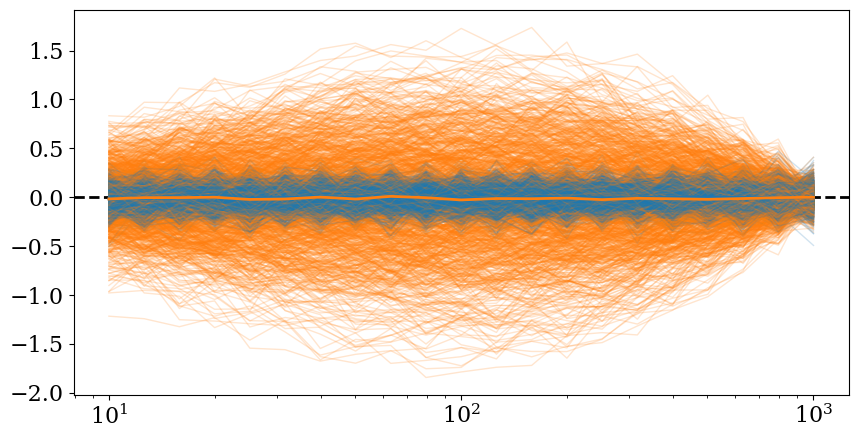

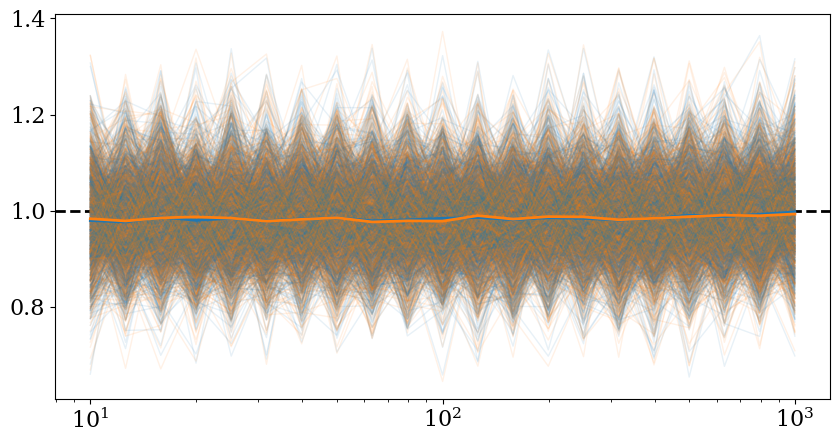

In [323]:
flux_level_ind = 0
b_ind = 0
key = list(b_amp_results_dict.keys())[b_ind]

summaries_with_b = np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_with_bs'],percentiles,axis=1)
means_with_b = summaries_with_b[1]
widths_with_b = 0.5*(summaries_with_b[2]-summaries_with_b[0])
summaries_no_b = np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_no_bs'],percentiles,axis=1)
means_no_b = summaries_no_b[1]
widths_no_b = 0.5*(summaries_no_b[2]-summaries_no_b[0])

plt.figure(figsize=(10,5))
ax = plt.gca()
ax.set_xscale('log')
plt.axhline(0,c='k',lw=2,ls='--')
for j in range(len(means_with_b)):
    plt.plot(test_range_fluxes,means_with_b[j],color='C0',alpha=0.2,lw=1)
    plt.plot(test_range_fluxes,means_no_b[j],color='C1',alpha=0.2,lw=1)
plt.plot(test_range_fluxes,
         np.nanpercentile(means_with_b,percentiles,axis=0)[1],
         color='C0',lw=2)
plt.plot(test_range_fluxes,
         np.nanpercentile(means_no_b,percentiles,axis=0)[1],
         color='C1',lw=2)
plt.show()

plt.figure(figsize=(10,5))
ax = plt.gca()
ax.set_xscale('log')
plt.axhline(1.00,c='k',lw=2,ls='--')
for j in range(len(widths_with_b)):
    plt.plot(test_range_fluxes,widths_with_b[j],color='C0',alpha=0.1,lw=1)
    plt.plot(test_range_fluxes,widths_no_b[j],color='C1',alpha=0.1,lw=1)
plt.plot(test_range_fluxes,
         np.nanpercentile(widths_with_b,percentiles,axis=0)[1],
         color='C0',lw=2)
plt.plot(test_range_fluxes,
         np.nanpercentile(widths_no_b,percentiles,axis=0)[1],
         color='C1',lw=2)

plt.show()



In [324]:
plot_dict = {
    'with_b':{},
    'no_b':{},
}

all_mean_scatters_with_b = np.zeros((len(b_amp_results_dict.keys()),len(test_range_fluxes)))
all_mean_scatters_no_b = np.zeros((len(b_amp_results_dict.keys()),len(test_range_fluxes)))

all_mean_scatters_2s_with_b = np.zeros((len(b_amp_results_dict.keys()),len(test_range_fluxes)))
all_mean_scatters_2s_no_b = np.zeros((len(b_amp_results_dict.keys()),len(test_range_fluxes)))

all_mean_means_with_b = np.zeros((len(b_amp_results_dict.keys()),len(test_range_fluxes)))
all_mean_means_no_b = np.zeros((len(b_amp_results_dict.keys()),len(test_range_fluxes)))

for b_ind,key in enumerate(b_amp_results_dict.keys()):
    if b_ind == 0:
        plot_dict['with_b']['flux_uncertainty'] = {}
        plot_dict['no_b']['flux_uncertainty'] = {}

    plot_dict['with_b']['flux_uncertainty'][b_ind] = np.nanpercentile(np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_errs_with_bs'],
                                              percentiles,axis=0)[1],
                                         percentiles,axis=0)
    plot_dict['no_b']['flux_uncertainty'][b_ind] = np.nanpercentile(np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_errs_no_bs'],
                                              percentiles,axis=0)[1],
                                         percentiles,axis=0)

    summaries_with_b = np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_with_bs'],percentiles,axis=1)
    means_with_b = summaries_with_b[1]
    widths_with_b = 0.5*(summaries_with_b[2]-summaries_with_b[0])
    mean_summaries_with_b = np.nanpercentile(means_with_b,percentiles,axis=0)
    width_summaries_with_b = np.nanpercentile(widths_with_b,percentiles,axis=0)
    widths_2s_with_b = 0.5*(np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_with_bs'],percentiles_2sigma[1],axis=1)\
                            -np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_with_bs'],percentiles_2sigma[0],axis=1))
    width_2s_summaries_with_b = np.nanpercentile(widths_2s_with_b,percentiles,axis=0)
    summaries_no_b = np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_no_bs'],percentiles,axis=1)
    means_no_b = summaries_no_b[1]
    widths_no_b = 0.5*(summaries_no_b[2]-summaries_no_b[0])
    mean_summaries_no_b = np.nanpercentile(means_no_b,percentiles,axis=0)
    width_summaries_no_b = np.nanpercentile(widths_no_b,percentiles,axis=0)
    widths_2s_no_b = 0.5*(np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_no_bs'],percentiles_2sigma[1],axis=1)\
                            -np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_no_bs'],percentiles_2sigma[0],axis=1))
    width_2s_summaries_no_b = np.nanpercentile(widths_2s_no_b,percentiles,axis=0)

    all_mean_scatters_with_b[b_ind] = 0.5*(mean_summaries_with_b[2]-mean_summaries_with_b[0])
    all_mean_scatters_no_b[b_ind] = 0.5*(mean_summaries_no_b[2]-mean_summaries_no_b[0])
    # all_mean_scatters_2s_with_b[b_ind] = 0.5*(mean_summaries_with_b[2]-mean_summaries_with_b[0])
    # all_mean_scatters_2s_no_b[b_ind] = 0.5*(mean_summaries_no_b[2]-mean_summaries_no_b[0])
    all_mean_means_with_b[b_ind] = mean_summaries_with_b[1]
    all_mean_means_no_b[b_ind] = mean_summaries_no_b[1]



In [325]:
flux_level_ind,key

(0, 'unif_draw_amp_0.00')

In [ ]:
widths = np.array([0.5,0.68,0.9,0.95,0.99])*100
flux_level_ind = 0

b_amps = np.zeros(len(b_amp_results_dict.keys()))
for b_ind,key in enumerate(b_amp_results_dict.keys()):
    b_amp = float(key.split('_')[-1])
    b_amps[b_ind] = b_amp

cm = matplotlib.cm.jet
norm = matplotlib.colors.Normalize(vmin=widths.min(),vmax=widths.max())
# create a ScalarMappable and initialize a data structure
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])

for b_ind,key in enumerate(b_amp_results_dict.keys()):
    b_amp = float(key.split('_')[-1])
    # if b_amp != 0.5:
    #     continue
    
    summaries_with_b = np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_with_bs'],percentiles,axis=1)
    means_with_b = summaries_with_b[1]

    summaries_no_b = np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_no_bs'],percentiles,axis=1)
    means_no_b = summaries_no_b[1]

    plt.figure(figsize=(8,5))
    plt.title(r'$b_\mathrm{amp} = %.1f$'%b_amp,pad=20)
    ax = plt.gca()
    plt.minorticks_on()
    ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

    ax.set_xscale('log')
    for width_ind,width in enumerate(widths):
        color = sm.to_rgba(width)

        # curr_summary = 0.5*np.diff(np.nanpercentile(means_with_b,np.array([0.5-width*0.5,0.5+width*0.5])*100,axis=0),axis=0)[0]
        # plt.plot(test_range_fluxes,
        #          curr_summary,
        #          ls=':',lw=2,color='C%d'%width_ind)
        # curr_summary = 0.5*np.diff(np.nanpercentile(means_no_b,np.array([0.5-width*0.5,0.5+width*0.5])*100,axis=0),axis=0)[0]
        # plt.plot(test_range_fluxes,
        #          curr_summary,
        #          ls='-',lw=2,color='C%d'%width_ind)
        curr_summary = 0.5*np.diff(np.nanpercentile(means_no_b,[50-width*0.5,50+width*0.5],axis=0),axis=0)[0]\
                      -0.5*np.diff(np.nanpercentile(means_with_b,[50-width*0.5,50+width*0.5],axis=0),axis=0)[0]
        plt.plot(test_range_fluxes,
                 curr_summary,
                 ls='-',lw=2,color=color)
    cax = plt.colorbar(sm,label='Percentile')
    cax.set_ticks(widths)
    cax.set_ticklabels(np.round(widths).astype(int))
    plt.axhline(0,c='k',ls='--',lw=2)
    plt.ylabel('Magnitude of'+r' $(\vec f \mid \vec b)$'+'\n Z-score Bias')
    plt.xlabel(r'True Flux ($e^{-}$)')
    plt.tight_layout()
    plt.savefig(f'{plotpath}repeat_fit_model_bias_level_bamp%03d.png'%(b_amp*100))
    plt.show()
    # break
    

In [ ]:
key

In [ ]:
widths = np.array([0.5,0.68,0.9,0.95,0.99])*100
flux_level_ind = 0

b_amps = np.zeros(len(b_amp_results_dict.keys()))
for b_ind,key in enumerate(b_amp_results_dict.keys()):
    b_amp = float(key.split('_')[-1])
    b_amps[b_ind] = b_amp

cm = matplotlib.cm.jet
norm = matplotlib.colors.Normalize(vmin=widths.min(),vmax=widths.max())
# create a ScalarMappable and initialize a data structure
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])

plot_b_amps = [1.0,0.5,0.2]
plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(len(plot_b_amps),2,hspace=0.1, wspace=0.04, width_ratios=[1,0.03],
                       left=0.16, right=0.9, top=0.98, bottom = 0.1)


for b_ind,b_amp in enumerate(plot_b_amps):
    key = 'unif_draw_amp_%.2f'%(b_amp)
    
    summaries_with_b = np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_with_bs'],percentiles,axis=1)
    means_with_b = summaries_with_b[1]

    summaries_no_b = np.nanpercentile(b_amp_results_dict[key][flux_level_ind]['all_f_given_b_zscores_no_bs'],percentiles,axis=1)
    means_no_b = summaries_no_b[1]

    ax = plt.subplot(gs[b_ind,0])
    plt.minorticks_on()
    ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

    ax.set_xscale('log')
    for width_ind,width in enumerate(widths):
        color = sm.to_rgba(width)

        # curr_summary = 0.5*np.diff(np.nanpercentile(means_with_b,np.array([0.5-width*0.5,0.5+width*0.5])*100,axis=0),axis=0)[0]
        # plt.plot(test_range_fluxes,
        #          curr_summary,
        #          ls=':',lw=2,color='C%d'%width_ind)
        # curr_summary = 0.5*np.diff(np.nanpercentile(means_no_b,np.array([0.5-width*0.5,0.5+width*0.5])*100,axis=0),axis=0)[0]
        # plt.plot(test_range_fluxes,
        #          curr_summary,
        #          ls='-',lw=2,color='C%d'%width_ind)
        curr_summary = 0.5*np.diff(np.nanpercentile(means_no_b,[50-width*0.5,50+width*0.5],axis=0),axis=0)[0]\
                      -0.5*np.diff(np.nanpercentile(means_with_b,[50-width*0.5,50+width*0.5],axis=0),axis=0)[0]
        plt.plot(test_range_fluxes,
                 curr_summary,
                 ls='-',lw=2,color=color)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plt.text(xlim[0],ylim[1],'\n'+r'   $b_\mathrm{amp} = %.1f$'%b_amp,
            ha='left',va='top')
    if b_ind != len(plot_b_amps)-1:
        ax.set_xticklabels([])
    plt.ylabel('Magnitude of'+r' $(\vec f \mid \vec b)$'+'\n Z-score Bias')
    plt.axhline(0,c='k',ls='--',lw=2)
plt.xlabel(r'True Flux ($e^{-}$)')

cax = plt.subplot(gs[:3,1])
cax = plt.colorbar(sm,ax=ax,cax=cax,label='Percentile')
cax.set_ticks(widths)
cax.set_ticklabels(np.round(widths).astype(int))
plt.tight_layout()
plt.savefig(f'{plotpath}repeat_fit_model_bias_level_bamp.png')
plt.show()
# break
    

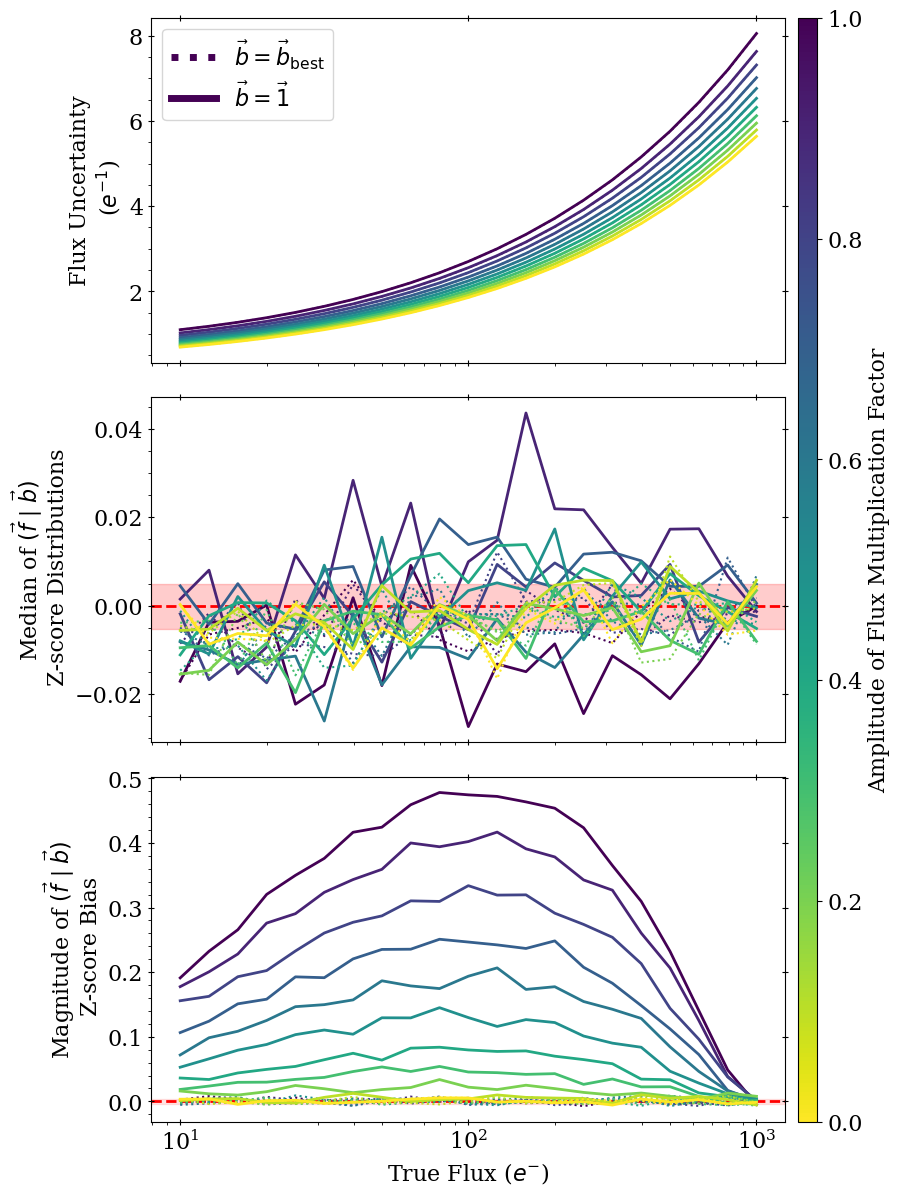

In [10]:


b_amps = np.zeros(len(b_amp_results_dict.keys()))
for b_ind,key in enumerate(b_amp_results_dict.keys()):
    b_amp = float(key.split('_')[-1])
    b_amps[b_ind] = b_amp

cm = matplotlib.cm.viridis_r
norm = matplotlib.colors.Normalize(vmin=b_amps.min(),vmax=b_amps.max())
# create a ScalarMappable and initialize a data structure
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])


# plt.figure(figsize=(10,5))
# ax = plt.gca()
plt.figure(figsize=(9,12))
gs = gridspec.GridSpec(3,2,hspace=0.1, wspace=0.04, width_ratios=[1,0.03],
                       left=0.16, right=0.9, top=0.98, bottom = 0.06)
ax = plt.subplot(gs[0,0])   

ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

for b_ind,key in enumerate(b_amp_results_dict.keys()):
    color = 'C%d'%b_ind
    color = sm.to_rgba(b_amps[b_ind])

    new_with_b_summary = plot_dict['with_b']['flux_uncertainty'][b_ind]
    new_no_b_summary = plot_dict['no_b']['flux_uncertainty'][b_ind]

    if b_ind == 0:
        label_with_b = r'$\vec b = \vec b_{\mathrm{best}}$'
        label_no_b = r'$\vec b = \vec 1$'
    else:
        label_with_b = ''
        label_no_b = ''
    plt.plot(test_range_fluxes,new_with_b_summary[1],color=color,ls=':',label=label_with_b)
    plt.plot(test_range_fluxes,new_no_b_summary[1],color=color,ls='-',lw=2,label=label_no_b)
    
    # plt.errorbar(test_range_fluxes*x_offsets[2*b_ind],
    #         new_with_b_summary[1],
    #         yerr=np.abs(new_with_b_summary[[0,2]]-new_with_b_summary[1]),
    #         color=color,fmt='o')
    # plt.errorbar(test_range_fluxes*x_offsets[2*b_ind+1],
    #         new_no_b_summary[1],
    #         yerr=np.abs(new_no_b_summary[[0,2]]-new_no_b_summary[1]),
    #         color=color,fmt='o')

# plt.colorbar(sm,ax=ax,label='Amblitude of Flux\n Multiplication Factor')

plt.ylabel('Flux Uncertainty\n'+' ($e^{-1}$)')
# plt.xlabel(r'True Flux ($e^{-1}$)')
ax.set_xticklabels([])
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(5.0)
# plt.show()

cm = matplotlib.cm.viridis_r
norm = matplotlib.colors.Normalize(vmin=b_amps.min(),vmax=b_amps.max())
# create a ScalarMappable and initialize a data structure
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])

ax = plt.subplot(gs[1,0])    
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
# plt.figure(figsize=(10,5))
# ax = plt.gca()
# ax.set_xscale('log')
plt.axhline(norm_mean_est,c='r',lw=2,ls='--',zorder=-1e10)
plt.axhspan(norm_mean_est-norm_mean_std_est,norm_mean_est+norm_mean_std_est,
            color='r',alpha=0.2,zorder=-1e10)

for b_ind,key in enumerate(b_amp_results_dict.keys()):

    color = 'C%d'%b_ind
    color = sm.to_rgba(b_amps[b_ind])

    if b_ind == 0:
        label_with_b = r'$\vec b = \vec b_{\mathrm{best}}$'
        label_no_b = r'$\vec b = \vec 1$'
    else:
        label_with_b = ''
        label_no_b = ''

    plt.plot(test_range_fluxes,all_mean_means_with_b[b_ind],color=color,ls=':',label=label_with_b)
    plt.plot(test_range_fluxes,all_mean_means_no_b[b_ind],color=color,ls='-',lw=2,label=label_no_b)
    
    # plt.errorbar(test_range_fluxes*x_offsets[2*b_ind],
    #         new_with_b_summary[1],
    #         yerr=np.abs(new_with_b_summary[[0,2]]-new_with_b_summary[1]),
    #         color=color,fmt='o')
    # plt.errorbar(test_range_fluxes*x_offsets[2*b_ind+1],
    #         new_no_b_summary[1],
    #         yerr=np.abs(new_no_b_summary[[0,2]]-new_no_b_summary[1]),
    #         color=color,fmt='o')

plt.ylabel(r'Median of $(\vec f \mid \vec b)$'+'\n Z-score Distributions')
# plt.xlabel(f'True Flux ($e^-$)')
# leg = plt.legend()
# for line in leg.get_lines():
#     line.set_linewidth(5.0)
# ylim = np.array(plt.ylim())
# ax1 = ax.twinx()
# ax1.set_ylim((ylim-norm_mean_est)/norm_mean_std_est)
# ax1.set_ylabel(r'$\sigma$ from Expectation')
ax.set_xticklabels([])

# plt.show()

ax = plt.subplot(gs[2,0])    
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

# plt.figure(figsize=(10,5))
# ax = plt.gca()
# ax.set_xscale('log')
plt.axhline(norm_mean_width_est-norm_mean_width_est,c='r',lw=2,ls='--',zorder=-1e10)
plt.axhspan(norm_mean_width_bounds_est[0]-norm_mean_width_est,norm_mean_width_bounds_est[1]-norm_mean_width_est,
            color='r',alpha=0.1,zorder=-1e10)

for b_ind,key in enumerate(b_amp_results_dict.keys()):

    color = 'C%d'%b_ind
    color = sm.to_rgba(b_amps[b_ind])

    if b_ind == 0:
        label_with_b = r'$\vec b = \vec b_{\mathrm{best}}$'
        label_no_b = r'$\vec b = \vec 1$'
    else:
        label_with_b = ''
        label_no_b = ''

    plt.plot(test_range_fluxes,
             all_mean_scatters_with_b[b_ind]-norm_mean_width_est,
             color=color,ls=':',label=label_with_b)
    plt.plot(test_range_fluxes,
             all_mean_scatters_no_b[b_ind]-norm_mean_width_est,
             color=color,ls='-',lw=2,label=label_no_b)
    
    # plt.errorbar(test_range_fluxes*x_offsets[2*b_ind],
    #         new_with_b_summary[1],
    #         yerr=np.abs(new_with_b_summary[[0,2]]-new_with_b_summary[1]),
    #         color=color,fmt='o')
    # plt.errorbar(test_range_fluxes*x_offsets[2*b_ind+1],
    #         new_no_b_summary[1],
    #         yerr=np.abs(new_no_b_summary[[0,2]]-new_no_b_summary[1]),
    #         color=color,fmt='o')

# plt.ylabel('StDev of Median'+r' of $(\vec f \mid \vec b)$'+'\n Z-score Distributions')
plt.ylabel('Magnitude of'+r' $(\vec f \mid \vec b)$'+'\n Z-score Bias')
plt.xlabel(r'True Flux ($e^{-}$)')
# leg = plt.legend()
# for line in leg.get_lines():
#     line.set_linewidth(5.0)
plt.colorbar(sm,ax=ax,cax=plt.subplot(gs[:3,1]),label='Amplitude of Flux Multiplication Factor')
# ylim = np.array(plt.ylim())
# ax1 = ax.twinx()
# ax1.set_ylim((ylim-norm_mean_width_est)/norm_mean_width_std_est)
# ax1.set_ylabel(r'$\sigma$ from Expectation')
# plt.show()

plt.savefig(f'{plotpath}repeat_fit_model_bias.png')
plt.show()


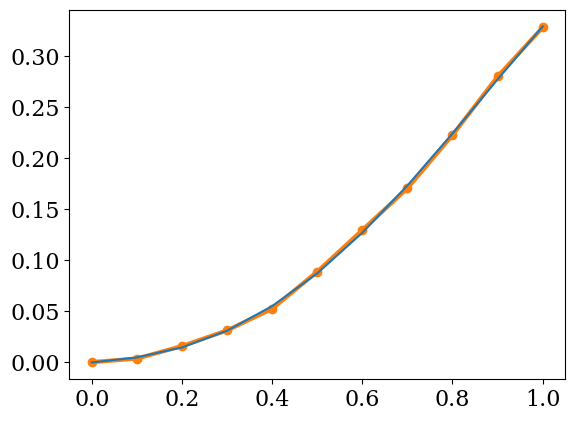

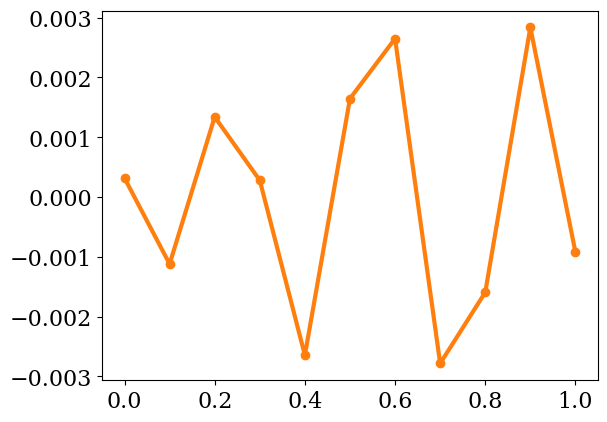

In [407]:
x,y = b_amps,means_no_b
model = np.poly1d(np.polyfit(b_amps,means_no_b,4))

plt.plot(x,y,label=r'$\vec b = \vec 1$',lw=3,marker='o',color='C1')
plt.plot(x,model(x))
plt.show()

plt.plot(x,y-model(x),label=r'$\vec b = \vec 1$',lw=3,marker='o',color='C1')
plt.show()


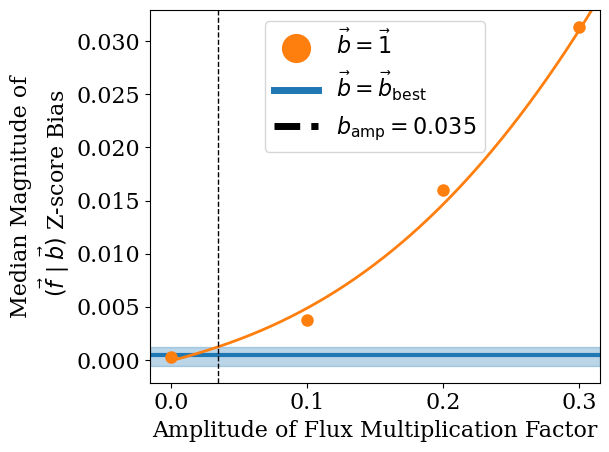

In [418]:
b_amps = np.zeros(len(b_amp_results_dict.keys()))
for b_ind,key in enumerate(b_amp_results_dict.keys()):
    b_amp = float(key.split('_')[-1])
    b_amps[b_ind] = b_amp

cm = matplotlib.cm.viridis_r
norm = matplotlib.colors.Normalize(vmin=b_amps.min(),vmax=b_amps.max())
# create a ScalarMappable and initialize a data structure
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])


plt.figure()
means_with_b = np.zeros(len(b_amp_results_dict))
means_no_b = np.zeros(len(b_amp_results_dict))
errs_with_b = np.zeros((len(b_amp_results_dict),2))
errs_no_b = np.zeros((len(b_amp_results_dict),2))

for b_ind,key in enumerate(b_amps):

    color = 'C%d'%b_ind
    color = sm.to_rgba(b_amps[b_ind])

    if b_ind == 0:
        label_with_b = r'$\vec b = \vec b_{\mathrm{best}}$'
        label_no_b = r'$\vec b = \vec 1$'
    else:
        label_with_b = ''
        label_no_b = ''

    # means_with_b[b_ind] = np.nanmedian(all_mean_scatters_with_b[b_ind]-norm_mean_width_est)
    # means_no_b[b_ind] = np.nanmedian(all_mean_scatters_no_b[b_ind]-norm_mean_width_est)
    means_with_b[b_ind] = np.nanmean(all_mean_scatters_with_b[b_ind]-norm_mean_width_est)
    means_no_b[b_ind] = np.nanmean(all_mean_scatters_no_b[b_ind]-norm_mean_width_est)
    errs_with_b[b_ind] = np.abs(np.nanpercentile(all_mean_scatters_with_b[b_ind]-norm_mean_width_est,[16,84])-means_with_b[b_ind])
    errs_no_b[b_ind] = np.abs(np.nanpercentile(all_mean_scatters_no_b[b_ind]-norm_mean_width_est,[16,84])-means_no_b[b_ind])
    # plt.scatter(b_amps[b_ind],
    #          np.nanmean(all_mean_scatters_with_b[b_ind]-norm_mean_width_est),
    #          color=color,label=label_with_b)
    # plt.scatter(b_amps[b_ind],
    #          np.nanmean(all_mean_scatters_no_b[b_ind]-norm_mean_width_est),
    #          color=color,label=label_no_b)

lo_ind = np.where(means_no_b <= means_with_b)[0][0]
hi_ind = np.where(means_no_b > means_with_b)[0][-1]

dx = b_amps[lo_ind]-b_amps[hi_ind]
slope_no_b = (means_no_b[lo_ind]-means_no_b[hi_ind])/dx
inter_no_b = means_no_b[lo_ind]-slope_no_b*(b_amps[lo_ind])

slope_with_b = (means_with_b[lo_ind]-means_with_b[hi_ind])/dx
inter_with_b = means_with_b[lo_ind]-slope_with_b*(b_amps[lo_ind])

# line1 = np.poly1d([slope_no_b,inter_no_b])
# line2 = np.poly1d([slope_with_b,inter_with_b])

# curr_x_vals = np.linspace(b_amps[lo_ind],b_amps[hi_ind],10000)
# yline1 = line1(curr_x_vals)
# yline2 = line2(curr_x_vals)

# intersect_ind = np.argmin(np.abs(yline1-yline2))
# intersect_x = curr_x_vals[intersect_ind]

# intersect_x = 

keep = (b_amps < 0.35)
# plt.plot(b_amps[keep],means_with_b[keep],label=r'$\vec b = \vec b_{\mathrm{best}}$',lw=3,marker='o')
plt.scatter(b_amps[keep],means_no_b[keep],label=r'$\vec b = \vec 1$',lw=3,marker='o',color='C1',zorder=1e10)
means_with_b_summary = np.nanpercentile(means_with_b,[5,50,95])
plt.axhline(means_with_b_summary[1],c='C0',lw=3,ls='-',label=r'$\vec b = \vec b_{\mathrm{best}}$')
plt.axhspan(means_with_b_summary[0],means_with_b_summary[2],color='C0',alpha=0.3)
ylim = plt.ylim()
xlim = plt.xlim()
# plt.plot(b_amps,means_no_b,lw=3,marker='o',color='C1')
xmodel = np.linspace(max(0,xlim[0]),xlim[1],10000)
plt.plot(xmodel,model(xmodel),lw=2,color='C1')

plt.xlim(xlim)
plt.ylim(ylim)

bias_mag_thresh = means_with_b_summary[2]

intersect_x = (bias_mag_thresh-inter_no_b)/slope_no_b
intersect_ind = np.argmin(np.abs(model(xmodel)-bias_mag_thresh))
intersect_x = xmodel[intersect_ind]


# plt.errorbar(b_amps[keep],means_with_b[keep],yerr=errs_with_b[keep].T,
#              label=r'$\vec b = \vec b_{\mathrm{best}}$',lw=3,fmt='-o')
# plt.errorbar(b_amps[keep],means_no_b[keep],yerr=errs_no_b[keep].T,
#              label=r'$\vec b = \vec 1$',lw=3,fmt='-o')
plt.axvline(intersect_x,c='k',lw=1,ls='--',label='$b_{\mathrm{amp}} = %.3f$'%(intersect_x))

# test = np.nanpercentile(all_mean_scatters_with_b-norm_mean_width_est,[16,50,84])
# plt.axhline(test[1],c='k',lw=1,ls='--')
# plt.axhspan(test[0],test[2],color='grey',alpha=0.1)


plt.xlabel(r'Amplitude of Flux Multiplication Factor')
plt.ylabel('Median Magnitude of\n'+r' $(\vec f \mid \vec b)$ Z-score Bias')
leg = plt.legend(loc='best',markerscale=3)
for line in leg.get_lines():
    line.set_linewidth(5)
plt.tight_layout()
plt.savefig(f'{plotpath}repeat_fit_model_bias_transition.png')
plt.show()


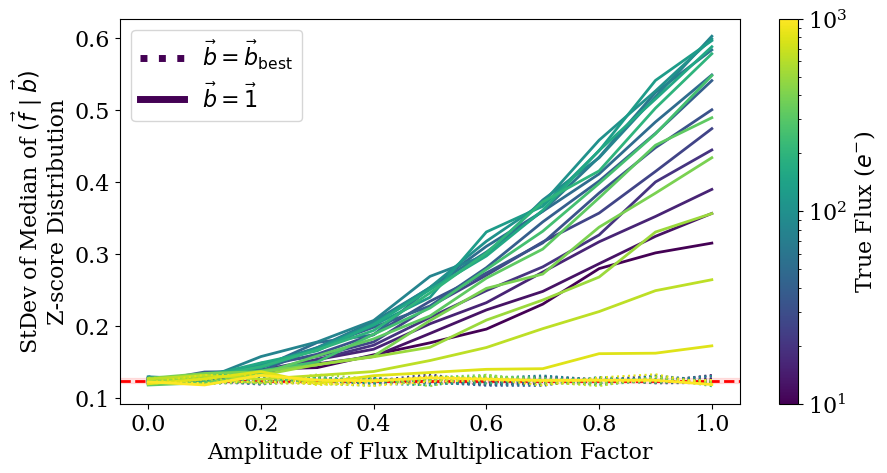

In [11]:
cm = matplotlib.cm.viridis
norm = matplotlib.colors.LogNorm(vmin=test_range_fluxes.min(),vmax=test_range_fluxes.max())
# create a ScalarMappable and initialize a data structure
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])


plt.figure(figsize=(10,5))
ax = plt.gca()
# ax.set_xscale('log')
plt.axhline(norm_mean_width_est,c='r',lw=2,ls='--',zorder=-1e10)
plt.axhspan(norm_mean_width_bounds_est[0],norm_mean_width_bounds_est[1],
            color='r',alpha=0.1,zorder=-1e10)

for flux_ind,flux_level in enumerate(test_range_fluxes):
    color = sm.to_rgba(flux_level)

    if flux_ind == 0:
        label_with_b = r'$\vec b = \vec b_{\mathrm{best}}$'
        label_no_b = r'$\vec b = \vec 1$'
    else:
        label_with_b = ''
        label_no_b = ''
    plt.plot(b_amps,
             all_mean_scatters_with_b[:,flux_ind],
             color=color,ls=':',label=label_with_b)
    plt.plot(b_amps,
             all_mean_scatters_no_b[:,flux_ind],
             color=color,ls='-',lw=2,label=label_no_b)
    
    # plt.errorbar(test_range_fluxes*x_offsets[2*b_ind],
    #         new_with_b_summary[1],
    #         yerr=np.abs(new_with_b_summary[[0,2]]-new_with_b_summary[1]),
    #         color=color,fmt='o')
    # plt.errorbar(test_range_fluxes*x_offsets[2*b_ind+1],
    #         new_no_b_summary[1],
    #         yerr=np.abs(new_no_b_summary[[0,2]]-new_no_b_summary[1]),
    #         color=color,fmt='o')

plt.xlabel('Amplitude of Flux Multiplication Factor')
plt.ylabel(r'StDev of Median of $(\vec f \mid \vec b)$'+'\n Z-score Distribution ')
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(5.0)
plt.colorbar(sm,ax=ax,label=r'True Flux ($e^{-}$)')
# ylim = np.array(plt.ylim())
# ax1 = ax.twinx()
# ax1.set_ylim((ylim-norm_mean_width_est)/norm_mean_width_std_est)
# ax1.set_ylabel(r'$\sigma$ from Expectation')
plt.show()

In [12]:
bad_inds = np.where(~np.isfinite(np.diag(b_vect_V)))[0]
test_b_V = np.copy(b_vect_V)
test_b_V[bad_inds] = 0
test_b_V[:,bad_inds] = 0
test_b_V[bad_inds,bad_inds] = np.nanmin(np.diag(b_vect_V))

n_b_samps = 10000 
#draw new b vector
curr_L = np.linalg.cholesky(test_b_V)
min_b_val = 1e-10
curr_b_draws = np.einsum('ij,nj->ni',curr_L,np.random.randn(n_b_samps,len(b_vect_mean)))+b_vect_mean
curr_b_draws[:,bad_inds] = b_vect_mean[bad_inds]
# comb_param_samps[s_ind,n_pixels:] = curr_b_draw
curr_b_draws = np.maximum(curr_b_draws,min_b_val)

curr_f_given_b_means_samps = np.zeros((n_b_samps,len(test_new_obs_fluxes)))
curr_f_given_b_ivars_samps = np.zeros((n_b_samps,len(test_new_obs_fluxes)))
curr_f_given_b_chi2s_samps = np.zeros((n_b_samps,len(test_new_obs_fluxes)))
for j in range(n_b_samps):
    curr_f_given_b_means_samps[j],\
            curr_f_given_b_ivars_samps[j],\
            curr_f_given_b_chi2s_samps[j] = fit_flux.fit_fluxes_optimal(test_new_obs_fluxes,
                                                            np.nanmedian(read_errs)*np.ones(n_test_range_pixels),
                                                            n_repeat=2,
                                                            b_vect=curr_b_draws[j])
curr_f_given_b_means,\
            curr_f_given_b_ivars,\
            curr_f_given_b_chi2s = fit_flux.fit_fluxes_optimal(test_new_obs_fluxes,
                                                            np.nanmedian(read_errs)*np.ones(n_test_range_pixels),
                                                            n_repeat=2,
                                                            b_vect=b_vect_mean)

curr_f_given_b_samps = curr_f_given_b_means_samps\
                            +np.random.randn(*curr_f_given_b_means_samps.shape)\
                                *np.power(curr_f_given_b_ivars_samps,-0.5)


In [13]:
new_test_b_V = np.copy(test_b_V)
new_test_b_V[bad_inds,bad_inds] = 0

tridiag_mult = np.eye(new_test_b_V.shape[0])
for j in range(len(tridiag_mult)):
    if j > 0:
        tridiag_mult[j,j-1] = 1
    if j < len(tridiag_mult)-1:
        tridiag_mult[j,j+1] = 1
tridiag_test_b_V = new_test_b_V*tridiag_mult
diag_test_b_V = np.eye(new_test_b_V.shape[0])*new_test_b_V

test_f_given_b_means,\
            test_f_given_b_ivars,\
            test_f_given_b_chi2s = fit_flux.fit_fluxes_optimal_with_bcov(test_new_obs_fluxes,
                                                            np.nanmedian(read_errs)*np.ones(n_test_range_pixels),
                                                            b_vect_mean,new_test_b_V,n_repeat=2)
tridaig_f_given_b_means,\
            tridaig_f_given_b_ivars,\
            tridaig_f_given_b_chi2s = fit_flux.fit_fluxes_optimal_with_bcov(test_new_obs_fluxes,
                                                            np.nanmedian(read_errs)*np.ones(n_test_range_pixels),
                                                            b_vect_mean,tridiag_test_b_V,n_repeat=2)
daig_f_given_b_means,\
            daig_f_given_b_ivars,\
            daig_f_given_b_chi2s = fit_flux.fit_fluxes_optimal_with_bcov(test_new_obs_fluxes,
                                                            np.nanmedian(read_errs)*np.ones(n_test_range_pixels),
                                                            b_vect_mean,diag_test_b_V,n_repeat=2)


In [23]:
#generate some synthetic data

np.random.seed(104)

n_reads = 33
# n_reads = 42
n_pixels = 100

#define the true multiplicative factor to the fluxes
true_b_vect = np.ones(n_reads-1)*1.0
true_b_vect = np.linspace(0.5,2.0,n_reads-1)
true_b_vect[n_reads//2:] = 1.0
true_b_vect /= true_b_vect.max()

true_b_vect = 1.0 - (np.random.rand(n_reads-1))*0.5
# true_b_vect[len(true_b_vect)//2] = np.max(true_b_vect)
# true_b_vect[0::2] = 1
# true_b_vect[1::2] = 0.5
# true_b_vect[np.argmax(true_b_vect)] = np.max(true_b_vect)*2
# true_b_vect[len(true_b_vect)//2] = np.max(true_b_vect)

# true_b_vect /= true_b_vect.max()

#set the read noise in each pixel
read_errs = ((np.random.rand(n_pixels)-0.5)*2)*5 + 19
# read_errs = ((np.random.rand(n_pixels)-0.5)*2)*5 + 28

#define true fluxes in each pixel
true_flux_dict = {
    'high':((np.random.rand(n_pixels)-0.5)*2)*200 + 1000,
    'mid':((np.random.rand(n_pixels)-0.5)*2)*50 + 100,
    'read_noise':((np.random.rand(n_pixels)-0.5)*2)*5 + 19,
    'low':((np.random.rand(n_pixels)-0.5)*2)*2 + 5,
}

true_flux_levels = np.array([1000,500,200,100,50,40,30,20,15,10,5,2,1])
# true_flux_levels = np.array([1000,100])
true_flux_dict = {}
for flux_level in true_flux_levels:
    true_flux_dict[flux_level] = np.ones(n_pixels)*flux_level


read_times = np.arange(n_reads)
read_diff_times = 0.5*(read_times[1:]+read_times[:-1])

#hard-to-measure low fluxes to be used with b vectors
test_low_fluxes = ((np.random.rand(n_pixels)-0.5)*2)*2 + 5


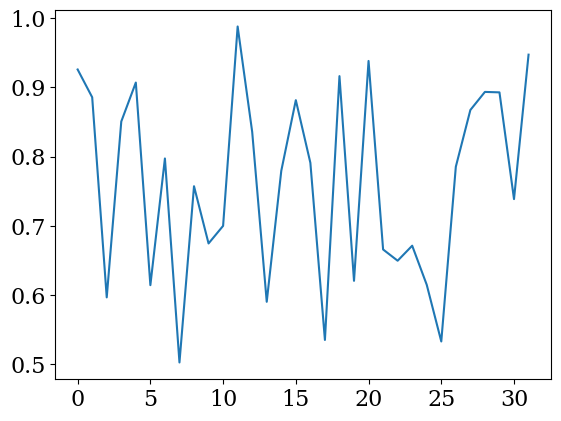

In [24]:
plt.plot(true_b_vect)
plt.show()

In [25]:

#number of times to redraw the data using the same true_b_vect, true_fluxes, read_errs
n_sim = 1000
# n_sim = 500
# n_sim = 200
# n_sim = 100
# n_sim = 50

results_dict = {}

np.random.seed(100)

for flux_level_ind,flux_level in enumerate(true_flux_dict):
    
    true_fluxes = true_flux_dict[flux_level]

    print(f'Fitting {n_sim} simulations of {flux_level} flux level data:')
    
    for s_ind,_ in enumerate(tqdm(np.arange(n_sim),total=n_sim)):
    
        #draw new data
        obs_fluxes = fit_flux.generate_data(read_errs,true_fluxes,true_b_vect)
        obs_fluxes_errs = np.sqrt(np.power(read_errs,2)+np.maximum(true_fluxes,0))
        obs_flux_diffs = np.diff(obs_fluxes,axis=1)
        # obs_flux_diff_errs = np.sqrt((read_err*2)**2+np.maximum(true_fluxes[:,1:],0))
        obs_flux_diff_errs = np.sqrt(np.power(read_errs*2,2)[:,None]+np.maximum(obs_flux_diffs,0))

        min_b_val=1e-10
        max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
                f_max_means_given_b,f_max_ivars_given_b,\
                comb_param_means,comb_param_Vinv,comb_param_V = fit_flux.measure_time_dep_fluxes_LINEAR(obs_fluxes,read_errs,
                                                               n_max_repeat=1000,b_vect_change_tol=1e-10,
                                                               min_b_val=min_b_val,min_f_val=1e-10,
                                                               rescale=True,true_b_vect=true_b_vect,
                                                               true_fluxes=true_fluxes,random_max_b=True)
    
        
        non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
        non_max_inds[max_b_ind] = False
        non_max_inds = np.where(non_max_inds)[0]
        
        b_vect_errs = np.sqrt(np.diag(b_vect_V))
        f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

        f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                       n_repeat=2,b_vect=None)
        #remember to scale the non-b-fit fluxes as well
        #to be fair for comparison

        mult_var = 1/np.sum(np.power(f_means_no_b,2)*f_ivars_no_b)
        mult_mean_no_b = mult_var * np.sum(f_means_no_b*true_fluxes*f_ivars_no_b)
        mult_mean_no_b = mult_mean_no_b + np.random.randn()*mult_var**0.5

        f_means_no_b *= mult_mean_no_b
        f_ivars_no_b /= mult_mean_no_b**2

        f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                                           n_repeat=2,
                                                                            b_vect=np.maximum(b_vect_mean,min_b_val))
        
        mult_var = 1/np.sum(np.power(f_means_with_b,2)*f_ivars_with_b)
        mult_mean_with_b = mult_var * np.sum(f_means_with_b*true_fluxes*f_ivars_with_b)
        mult_mean_with_b = mult_mean_with_b + np.random.randn()*mult_var**0.5

        f_means_with_b *= mult_mean_with_b
        f_ivars_with_b /= mult_mean_with_b**2

        # b_V_for_extract = np.copy(b_vect_V)
        # b_V_for_extract[max_b_ind] = 0
        # b_V_for_extract[:,max_b_ind] = 0
        
        # f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal_with_bcov(obs_fluxes,read_errs,
        #                                                             np.maximum(b_vect_mean,min_b_val),b_V_for_extract,
        #                                                                                         n_repeat=2)

        test_low_obs_fluxes = fit_flux.generate_data(read_errs,test_low_fluxes,true_b_vect)
        
        low_flux_f_means_no_b,\
                low_flux_f_ivars_no_b,\
                low_flux_chi2s_data_no_b = fit_flux.fit_fluxes_optimal(test_low_obs_fluxes,read_errs,
                                                                       n_repeat=2,b_vect=None)


        low_flux_f_means_no_b *= mult_mean_no_b
        low_flux_f_ivars_no_b /= mult_mean_no_b**2
        
        low_flux_f_means_with_b,\
                low_flux_f_ivars_with_b,\
                low_flux_chi2s_data_with_b = fit_flux.fit_fluxes_optimal(test_low_obs_fluxes,read_errs,
                                                                         n_repeat=2,
                                                                         b_vect=np.maximum(b_vect_mean,min_b_val))
        # low_flux_f_means_with_b,\
        #         low_flux_f_ivars_with_b,\
        #         low_flux_chi2s_data_with_b = fit_flux.fit_fluxes_optimal_with_bcov(test_low_obs_fluxes,read_errs,
        #                                                             np.maximum(b_vect_mean,min_b_val),b_V_for_extract,
        #                                                                                         n_repeat=2)

        low_flux_f_means_with_b *= mult_mean_with_b
        low_flux_f_ivars_with_b /= mult_mean_with_b**2
        
        if s_ind == 0:
            max_b_inds = np.zeros(n_sim).astype(int)
            b_vect_means = np.zeros((n_sim,*b_vect_mean.shape))
            b_vect_Vinvs = np.zeros((n_sim,*b_vect_Vinv.shape))
            b_vect_Vs = np.zeros((n_sim,*b_vect_V.shape))
            f_max_means_given_bs = np.zeros((n_sim,*f_max_means_given_b.shape))
            f_max_ivars_given_bs = np.zeros((n_sim,*f_max_ivars_given_b.shape))
            all_comb_param_means = np.zeros((n_sim,*comb_param_means.shape))
            all_comb_param_Vinvs = np.zeros((n_sim,*comb_param_Vinv.shape))
            all_comb_param_Vs = np.zeros((n_sim,*comb_param_V.shape))
            all_non_max_inds = np.zeros((n_sim,*non_max_inds.shape))
            all_b_vect_errs = np.zeros((n_sim,*b_vect_errs.shape))
            all_f_max_errs_given_bs = np.zeros((n_sim,*f_max_errs_given_b.shape))    
            
            all_f_max_zscores = np.zeros((n_sim,n_pixels))
            all_f_max_chi2s = np.zeros((n_sim))
            all_f_given_b_zscores = np.zeros((n_sim,n_pixels))
            all_f_given_b_chi2s = np.zeros((n_sim))
            
            all_b_vect_zscores = np.zeros((n_sim,n_reads-2))
            all_b_vect_chi2s = np.zeros((n_sim))
    
            all_comb_param_zscores = np.zeros((n_sim,len(comb_param_means)))
            all_comb_param_chi2s = np.zeros((n_sim))

            all_chi2s_data_no_bs = np.zeros((n_sim,*chi2s_data_no_b.shape))
            all_chi2s_data_with_bs = np.zeros((n_sim,*chi2s_data_with_b.shape))
            all_low_flux_chi2s_data_no_bs = np.zeros((n_sim,*low_flux_chi2s_data_no_b.shape))
            all_low_flux_chi2s_data_with_bs = np.zeros((n_sim,*low_flux_chi2s_data_with_b.shape))

            all_f_given_b_zscores_with_bs = np.zeros((n_sim,n_pixels))
            all_f_given_b_chi2s_with_bs = np.zeros((n_sim))
            all_f_given_b_zscores_no_bs = np.zeros((n_sim,n_pixels))
            all_f_given_b_chi2s_no_bs = np.zeros((n_sim))

    
        #save outputs, compare to truth, save summary statistics (like z-scores and chi2s)
        true_param_means = np.zeros_like(comb_param_means)
        true_param_means[:n_pixels] = true_fluxes
        true_param_means[n_pixels:] = true_b_vect[non_max_inds]
    
        max_b_inds[s_ind] = max_b_ind
        b_vect_means[s_ind] = b_vect_mean
        b_vect_Vinvs[s_ind] = b_vect_Vinv
        b_vect_Vs[s_ind] = b_vect_V
        f_max_means_given_bs[s_ind] = f_max_means_given_b
        f_max_ivars_given_bs[s_ind] = f_max_ivars_given_b
        all_comb_param_means[s_ind] = comb_param_means
        all_comb_param_Vinvs[s_ind] = comb_param_Vinv
        all_comb_param_Vs[s_ind] = comb_param_V
        all_non_max_inds[s_ind] = non_max_inds
        all_b_vect_errs[s_ind] = b_vect_errs
        all_f_max_errs_given_bs[s_ind] = f_max_errs_given_b
    
        all_b_vect_zscores[s_ind] = (b_vect_mean[non_max_inds]-true_b_vect[non_max_inds])/b_vect_errs[non_max_inds]
        all_f_max_zscores[s_ind] = (comb_param_means[:n_pixels]-true_fluxes)/np.sqrt(np.diag(comb_param_V)[:n_pixels])
        all_f_given_b_zscores[s_ind] = (f_max_means_given_b-true_fluxes)*np.sqrt(f_max_ivars_given_b)
        all_f_given_b_chi2s[s_ind] = np.sum(np.power(all_f_given_b_zscores[s_ind],2))
        all_comb_param_zscores[s_ind] = (comb_param_means-true_param_means)/np.sqrt(np.diag(comb_param_V))
        
        diff = comb_param_means-true_param_means
        all_comb_param_chi2s[s_ind] = np.dot(diff,np.dot(comb_param_Vinv,diff))
        diff = (comb_param_means-true_param_means)[n_pixels:]
        all_b_vect_chi2s[s_ind] = np.dot(diff,np.dot(comb_param_Vinv[n_pixels:,n_pixels:],diff))
        diff = (comb_param_means-true_param_means)[:n_pixels]
        all_f_max_chi2s[s_ind] = np.dot(diff,np.dot(comb_param_Vinv[:n_pixels,:n_pixels],diff))

        all_chi2s_data_no_bs[s_ind] = chi2s_data_no_b
        all_chi2s_data_with_bs[s_ind] = chi2s_data_with_b
        all_low_flux_chi2s_data_no_bs[s_ind] = low_flux_chi2s_data_no_b
        all_low_flux_chi2s_data_with_bs[s_ind] = low_flux_chi2s_data_with_b

        all_f_given_b_zscores_with_bs[s_ind] = (f_means_with_b-true_fluxes)*np.sqrt(f_ivars_with_b)
        all_f_given_b_chi2s_with_bs[s_ind] = np.sum(np.power(all_f_given_b_zscores_with_bs[s_ind],2))
        all_f_given_b_zscores_no_bs[s_ind] = (f_means_no_b-true_fluxes)*np.sqrt(f_ivars_no_b)
        all_f_given_b_chi2s_no_bs[s_ind] = np.sum(np.power(all_f_given_b_zscores_no_bs[s_ind],2))

    
    results_dict[flux_level] = {
        'max_b_inds':max_b_inds,
        'b_vect_means':b_vect_means,
        'b_vect_Vinvs':b_vect_Vinvs,
        'b_vect_Vs':b_vect_Vs,
        'all_b_vect_errs':all_b_vect_errs,
        'all_b_vect_zscores':all_b_vect_zscores,
        'all_f_max_zscores':all_b_vect_zscores,
        'all_f_given_b_zscores':all_f_given_b_zscores,
        'all_f_given_b_chi2s':all_f_given_b_chi2s,
        'all_f_given_b_zscores_with_bs':all_f_given_b_zscores_with_bs,
        'all_f_given_b_chi2s_with_bs':all_f_given_b_chi2s_with_bs,
        'all_f_given_b_zscores_no_bs':all_f_given_b_zscores_no_bs,
        'all_f_given_b_chi2s_no_bs':all_f_given_b_chi2s_no_bs,
        'all_comb_param_zscores':all_comb_param_zscores,
        'all_comb_param_chi2s':all_comb_param_chi2s,
        'all_b_vect_chi2s':all_b_vect_chi2s,
        'all_f_max_chi2s':all_f_max_chi2s,
        'all_chi2s_data_no_bs':all_chi2s_data_no_bs,
        'all_chi2s_data_with_bs':all_chi2s_data_with_bs,
        'all_low_flux_chi2s_data_no_bs':all_low_flux_chi2s_data_no_bs,
        'all_low_flux_chi2s_data_with_bs':all_low_flux_chi2s_data_with_bs,
    }
    
    print('Done')


Fitting 1000 simulations of 1000 flux level data:


100%|███████████████████████████████████████| 1000/1000 [03:17<00:00,  5.06it/s]


Done
Fitting 1000 simulations of 500 flux level data:


100%|███████████████████████████████████████| 1000/1000 [03:44<00:00,  4.46it/s]


Done
Fitting 1000 simulations of 200 flux level data:


100%|███████████████████████████████████████| 1000/1000 [04:12<00:00,  3.96it/s]


Done
Fitting 1000 simulations of 100 flux level data:


100%|███████████████████████████████████████| 1000/1000 [04:47<00:00,  3.47it/s]


Done
Fitting 1000 simulations of 50 flux level data:


100%|███████████████████████████████████████| 1000/1000 [05:24<00:00,  3.08it/s]


Done
Fitting 1000 simulations of 40 flux level data:


100%|███████████████████████████████████████| 1000/1000 [05:37<00:00,  2.96it/s]


Done
Fitting 1000 simulations of 30 flux level data:


100%|███████████████████████████████████████| 1000/1000 [06:02<00:00,  2.76it/s]


Done
Fitting 1000 simulations of 20 flux level data:


100%|███████████████████████████████████████| 1000/1000 [06:33<00:00,  2.54it/s]


Done
Fitting 1000 simulations of 15 flux level data:


100%|███████████████████████████████████████| 1000/1000 [07:05<00:00,  2.35it/s]


Done
Fitting 1000 simulations of 10 flux level data:


100%|███████████████████████████████████████| 1000/1000 [12:30<00:00,  1.33it/s]


Done
Fitting 1000 simulations of 5 flux level data:


  3%|█▏                                     | 32/1000 [02:43<1:40:56,  6.26s/it]/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_45820/4156502040.py:41: RuntimeWarning: invalid value encountered in sqrt
  b_vect_errs = np.sqrt(np.diag(b_vect_V))
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_45820/4156502040.py:155: RuntimeWarning: invalid value encountered in sqrt
  all_f_max_zscores[s_ind] = (comb_param_means[:n_pixels]-true_fluxes)/np.sqrt(np.diag(comb_param_V)[:n_pixels])
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_45820/4156502040.py:158: RuntimeWarning: invalid value encountered in sqrt
  all_comb_param_zscores[s_ind] = (comb_param_means-true_param_means)/np.sqrt(np.diag(comb_param_V))
100%|█████████████████████████████████████| 1000/1000 [1:11:48<00:00,  4.31s/it]


Done
Fitting 1000 simulations of 2 flux level data:


 96%|████████████████████████████████████▌ | 962/1000 [2:50:51<06:44, 10.66s/it]


LinAlgError: Singular matrix

In [32]:
if s_ind != n_sim-1:
    results_dict[flux_level] = {
        'max_b_inds':max_b_inds[:s_ind],
        'b_vect_means':b_vect_means[:s_ind],
        'b_vect_Vinvs':b_vect_Vinvs[:s_ind],
        'b_vect_Vs':b_vect_Vs[:s_ind],
        'all_b_vect_errs':all_b_vect_errs[:s_ind],
        'all_b_vect_zscores':all_b_vect_zscores[:s_ind],
        'all_f_max_zscores':all_b_vect_zscores[:s_ind],
        'all_f_given_b_zscores':all_f_given_b_zscores[:s_ind],
        'all_f_given_b_chi2s':all_f_given_b_chi2s[:s_ind],
        'all_f_given_b_zscores_with_bs':all_f_given_b_zscores_with_bs[:s_ind],
        'all_f_given_b_chi2s_with_bs':all_f_given_b_chi2s_with_bs[:s_ind],
        'all_f_given_b_zscores_no_bs':all_f_given_b_zscores_no_bs[:s_ind],
        'all_f_given_b_chi2s_no_bs':all_f_given_b_chi2s_no_bs[:s_ind],
        'all_comb_param_zscores':all_comb_param_zscores[:s_ind],
        'all_comb_param_chi2s':all_comb_param_chi2s[:s_ind],
        'all_b_vect_chi2s':all_b_vect_chi2s[:s_ind],
        'all_f_max_chi2s':all_f_max_chi2s[:s_ind],
        'all_chi2s_data_no_bs':all_chi2s_data_no_bs[:s_ind],
        'all_chi2s_data_with_bs':all_chi2s_data_with_bs[:s_ind],
        'all_low_flux_chi2s_data_no_bs':all_low_flux_chi2s_data_no_bs[:s_ind],
        'all_low_flux_chi2s_data_with_bs':all_low_flux_chi2s_data_with_bs[:s_ind],
    }


In [33]:

# #number of times to redraw the data using the same true_b_vect, true_fluxes, read_errs
# n_sim = 1000
# n_sim = 1000
# # n_sim = 100
# # n_sim = 50

# np.random.seed(101)

# test_results_dict = {}

# for flux_level_ind,flux_level in enumerate(true_flux_dict):
    
#     true_fluxes = true_flux_dict[flux_level]

#     print(f'Fitting {n_sim} simulations of {flux_level} flux level data:')
    
#     for s_ind,_ in enumerate(tqdm(np.arange(n_sim),total=n_sim)):
    
#         #draw new data
#         obs_fluxes = fit_flux.generate_data(read_errs,true_fluxes,true_b_vect)
#         obs_fluxes_errs = np.sqrt(np.power(read_errs,2)+np.maximum(true_fluxes,0))
#         obs_flux_diffs = np.diff(obs_fluxes,axis=1)
#         # obs_flux_diff_errs = np.sqrt((read_err*2)**2+np.maximum(true_fluxes[:,1:],0))
#         obs_flux_diff_errs = np.sqrt(np.power(read_errs*2,2)[:,None]+np.maximum(obs_flux_diffs,0))

#         min_b_val=1e-10
#         max_b_ind,b_vect_mean,b_vect_Vinv,b_vect_V,\
#                 f_max_means_given_b,f_max_ivars_given_b,\
#                 comb_param_means,comb_param_Vinv,comb_param_V = fit_flux.measure_time_dep_fluxes_LINEAR(obs_fluxes,read_errs,
#                                                                n_max_repeat=1000,b_vect_change_tol=1e-10,
#                                                                min_b_val=min_b_val,min_f_val=1e-10,
#                                                                rescale=True,true_b_vect=true_b_vect,
#                                                                true_fluxes=true_fluxes,random_max_b=True)
    
        
#         non_max_inds = np.ones(len(b_vect_mean)).astype(bool)
#         non_max_inds[max_b_ind] = False
#         non_max_inds = np.where(non_max_inds)[0]
        
#         b_vect_errs = np.sqrt(np.diag(b_vect_V))
#         f_max_errs_given_b = np.power(f_max_ivars_given_b,-0.5)

#         f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
#                                                        n_repeat=2,b_vect=None)
#         #remember to scale the non-b-fit fluxes as well
#         #to be fair for comparison

#         mult_var = 1/np.sum(np.power(f_means_no_b,2)*f_ivars_no_b)
#         mult_mean_no_b = mult_var * np.sum(f_means_no_b*true_fluxes*f_ivars_no_b)

#         f_means_no_b *= mult_mean_no_b
#         f_ivars_no_b /= mult_mean_no_b**2

#         f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
#                                                                            n_repeat=2,
#                                                                             b_vect=np.maximum(b_vect_mean,min_b_val))
        
#         mult_var = 1/np.sum(np.power(f_means_with_b,2)*f_ivars_with_b)
#         mult_mean_with_b = mult_var * np.sum(f_means_with_b*true_fluxes*f_ivars_with_b)

#         f_means_with_b *= mult_mean_with_b
#         f_ivars_with_b /= mult_mean_with_b**2

#         # b_V_for_extract = np.copy(b_vect_V)
#         # b_V_for_extract[max_b_ind] = 0
#         # b_V_for_extract[:,max_b_ind] = 0
        
#         # f_means_with_b,f_ivars_with_b,chi2s_data_with_b = fit_flux.fit_fluxes_optimal_with_bcov(obs_fluxes,read_errs,
#         #                                                             np.maximum(b_vect_mean,min_b_val),b_V_for_extract,
#         #                                                                                         n_repeat=2)

#         test_low_obs_fluxes = fit_flux.generate_data(read_errs,test_low_fluxes,true_b_vect)
        
#         low_flux_f_means_no_b,\
#                 low_flux_f_ivars_no_b,\
#                 low_flux_chi2s_data_no_b = fit_flux.fit_fluxes_optimal(test_low_obs_fluxes,read_errs,
#                                                                        n_repeat=2,b_vect=None)


#         low_flux_f_means_no_b *= mult_mean_no_b
#         low_flux_f_ivars_no_b /= mult_mean_no_b**2
        
#         low_flux_f_means_with_b,\
#                 low_flux_f_ivars_with_b,\
#                 low_flux_chi2s_data_with_b = fit_flux.fit_fluxes_optimal(test_low_obs_fluxes,read_errs,
#                                                                          n_repeat=2,
#                                                                          b_vect=np.maximum(b_vect_mean,min_b_val))
#         # low_flux_f_means_with_b,\
#         #         low_flux_f_ivars_with_b,\
#         #         low_flux_chi2s_data_with_b = fit_flux.fit_fluxes_optimal_with_bcov(test_low_obs_fluxes,read_errs,
#         #                                                             np.maximum(b_vect_mean,min_b_val),b_V_for_extract,
#         #                                                                                         n_repeat=2)

#         low_flux_f_means_with_b *= mult_mean_with_b
#         low_flux_f_ivars_with_b /= mult_mean_with_b**2
        
#         if s_ind == 0:
#             max_b_inds = np.zeros(n_sim).astype(int)
#             b_vect_means = np.zeros((n_sim,*b_vect_mean.shape))
#             b_vect_Vinvs = np.zeros((n_sim,*b_vect_Vinv.shape))
#             b_vect_Vs = np.zeros((n_sim,*b_vect_V.shape))
#             f_max_means_given_bs = np.zeros((n_sim,*f_max_means_given_b.shape))
#             f_max_ivars_given_bs = np.zeros((n_sim,*f_max_ivars_given_b.shape))
#             all_comb_param_means = np.zeros((n_sim,*comb_param_means.shape))
#             all_comb_param_Vinvs = np.zeros((n_sim,*comb_param_Vinv.shape))
#             all_comb_param_Vs = np.zeros((n_sim,*comb_param_V.shape))
#             all_non_max_inds = np.zeros((n_sim,*non_max_inds.shape))
#             all_b_vect_errs = np.zeros((n_sim,*b_vect_errs.shape))
#             all_f_max_errs_given_bs = np.zeros((n_sim,*f_max_errs_given_b.shape))    
            
#             all_f_max_zscores = np.zeros((n_sim,n_pixels))
#             all_f_max_chi2s = np.zeros((n_sim))
#             all_f_given_b_zscores = np.zeros((n_sim,n_pixels))
#             all_f_given_b_chi2s = np.zeros((n_sim))
            
#             all_b_vect_zscores = np.zeros((n_sim,n_reads-2))
#             all_b_vect_chi2s = np.zeros((n_sim))
    
#             all_comb_param_zscores = np.zeros((n_sim,len(comb_param_means)))
#             all_comb_param_chi2s = np.zeros((n_sim))

#             all_chi2s_data_no_bs = np.zeros((n_sim,*chi2s_data_no_b.shape))
#             all_chi2s_data_with_bs = np.zeros((n_sim,*chi2s_data_with_b.shape))
#             all_low_flux_chi2s_data_no_bs = np.zeros((n_sim,*low_flux_chi2s_data_no_b.shape))
#             all_low_flux_chi2s_data_with_bs = np.zeros((n_sim,*low_flux_chi2s_data_with_b.shape))

#             all_f_given_b_zscores_with_bs = np.zeros((n_sim,n_pixels))
#             all_f_given_b_chi2s_with_bs = np.zeros((n_sim))
#             all_f_given_b_zscores_no_bs = np.zeros((n_sim,n_pixels))
#             all_f_given_b_chi2s_no_bs = np.zeros((n_sim))

    
#         #save outputs, compare to truth, save summary statistics (like z-scores and chi2s)
#         true_param_means = np.zeros_like(comb_param_means)
#         true_param_means[:n_pixels] = true_fluxes
#         true_param_means[n_pixels:] = true_b_vect[non_max_inds]
    
#         max_b_inds[s_ind] = max_b_ind
#         b_vect_means[s_ind] = b_vect_mean
#         b_vect_Vinvs[s_ind] = b_vect_Vinv
#         b_vect_Vs[s_ind] = b_vect_V
#         f_max_means_given_bs[s_ind] = f_max_means_given_b
#         f_max_ivars_given_bs[s_ind] = f_max_ivars_given_b
#         all_comb_param_means[s_ind] = comb_param_means
#         all_comb_param_Vinvs[s_ind] = comb_param_Vinv
#         all_comb_param_Vs[s_ind] = comb_param_V
#         all_non_max_inds[s_ind] = non_max_inds
#         all_b_vect_errs[s_ind] = b_vect_errs
#         all_f_max_errs_given_bs[s_ind] = f_max_errs_given_b
    
#         all_b_vect_zscores[s_ind] = (b_vect_mean[non_max_inds]-true_b_vect[non_max_inds])/b_vect_errs[non_max_inds]
#         all_f_max_zscores[s_ind] = (comb_param_means[:n_pixels]-true_fluxes)/np.sqrt(np.diag(comb_param_V)[:n_pixels])
#         all_f_given_b_zscores[s_ind] = (f_max_means_given_b-true_fluxes)*np.sqrt(f_max_ivars_given_b)
#         all_f_given_b_chi2s[s_ind] = np.sum(np.power(all_f_given_b_zscores[s_ind],2))
#         all_comb_param_zscores[s_ind] = (comb_param_means-true_param_means)/np.sqrt(np.diag(comb_param_V))
        
#         diff = comb_param_means-true_param_means
#         all_comb_param_chi2s[s_ind] = np.dot(diff,np.dot(comb_param_Vinv,diff))
#         diff = (comb_param_means-true_param_means)[n_pixels:]
#         all_b_vect_chi2s[s_ind] = np.dot(diff,np.dot(comb_param_Vinv[n_pixels:,n_pixels:],diff))
#         diff = (comb_param_means-true_param_means)[:n_pixels]
#         all_f_max_chi2s[s_ind] = np.dot(diff,np.dot(comb_param_Vinv[:n_pixels,:n_pixels],diff))

#         all_chi2s_data_no_bs[s_ind] = chi2s_data_no_b
#         all_chi2s_data_with_bs[s_ind] = chi2s_data_with_b
#         all_low_flux_chi2s_data_no_bs[s_ind] = low_flux_chi2s_data_no_b
#         all_low_flux_chi2s_data_with_bs[s_ind] = low_flux_chi2s_data_with_b

#         all_f_given_b_zscores_with_bs[s_ind] = (f_means_with_b-true_fluxes)*np.sqrt(f_ivars_with_b)
#         all_f_given_b_chi2s_with_bs[s_ind] = np.sum(np.power(all_f_given_b_zscores_with_bs[s_ind],2))
#         all_f_given_b_zscores_no_bs[s_ind] = (f_means_no_b-true_fluxes)*np.sqrt(f_ivars_no_b)
#         all_f_given_b_chi2s_no_bs[s_ind] = np.sum(np.power(all_f_given_b_zscores_no_bs[s_ind],2))

    
#     test_results_dict[flux_level] = {
#         'all_b_vect_zscores':all_b_vect_zscores,
#         'all_f_max_zscores':all_b_vect_zscores,
#         'all_f_given_b_zscores':all_f_given_b_zscores,
#         'all_f_given_b_chi2s':all_f_given_b_chi2s,
#         'all_f_given_b_zscores_with_bs':all_f_given_b_zscores_with_bs,
#         'all_f_given_b_chi2s_with_bs':all_f_given_b_chi2s_with_bs,
#         'all_f_given_b_zscores_no_bs':all_f_given_b_zscores_no_bs,
#         'all_f_given_b_chi2s_no_bs':all_f_given_b_chi2s_no_bs,
#         'all_comb_param_zscores':all_comb_param_zscores,
#         'all_comb_param_chi2s':all_comb_param_chi2s,
#         'all_b_vect_chi2s':all_b_vect_chi2s,
#         'all_f_max_chi2s':all_f_max_chi2s,
#         'all_chi2s_data_no_bs':all_chi2s_data_no_bs,
#         'all_chi2s_data_with_bs':all_chi2s_data_with_bs,
#         'all_low_flux_chi2s_data_no_bs':all_low_flux_chi2s_data_no_bs,
#         'all_low_flux_chi2s_data_with_bs':all_low_flux_chi2s_data_with_bs,
#     }
    
#     print('Done')
#     ajksjkhsjkh


In [34]:
#do fitting again, but now just using the time independent version of data and fitting
#for comparisons of flux zscore distribution expectations

n_sim = 1000*100
n_sim = 1000
# n_sim = 1000
# n_sim = 100
# n_sim = 50

time_indep_results_dict = {}

time_indep_b_vect = np.ones_like(true_b_vect)

for flux_level_ind,flux_level in enumerate(true_flux_dict):
    
    true_fluxes = true_flux_dict[flux_level]

    print(f'Fitting {n_sim} simulations of {flux_level} flux level data:')
    
    for s_ind,_ in enumerate(tqdm(np.arange(n_sim),total=n_sim)):
    
        np.random.seed((n_sim+1)*flux_level_ind+s_ind)
    
        #draw new data
        obs_fluxes = fit_flux.generate_data(read_errs,true_fluxes,time_indep_b_vect)
        obs_fluxes_errs = np.sqrt(np.power(read_errs,2)+np.maximum(true_fluxes,0))
        obs_flux_diffs = np.diff(obs_fluxes,axis=1)
        # obs_flux_diff_errs = np.sqrt((read_err*2)**2+np.maximum(true_fluxes[:,1:],0))
        obs_flux_diff_errs = np.sqrt(np.power(read_errs*2,2)[:,None]+np.maximum(obs_flux_diffs,0))

        f_means_no_b,f_ivars_no_b,chi2s_data_no_b = fit_flux.fit_fluxes_optimal(obs_fluxes,read_errs,
                                                       n_repeat=2,b_vect=None)
                
        if s_ind == 0:
            all_f_given_b_zscores_no_bs = np.zeros((n_sim,n_pixels))
            all_f_given_b_chi2s_no_bs = np.zeros((n_sim))
            all_f_given_b_data_chi2s_no_bs = np.zeros((n_sim,n_pixels))

        all_f_given_b_zscores_no_bs[s_ind] = (f_means_no_b-true_fluxes)*np.sqrt(f_ivars_no_b)
        all_f_given_b_chi2s_no_bs[s_ind] = np.sum(np.power(all_f_given_b_zscores_no_bs[s_ind],2))
        all_f_given_b_data_chi2s_no_bs[s_ind] = chi2s_data_no_b

    
    time_indep_results_dict[flux_level] = {
        'all_f_given_b_zscores_no_bs':all_f_given_b_zscores_no_bs,
        'all_f_given_b_chi2s_no_bs':all_f_given_b_chi2s_no_bs,
        'all_f_given_b_data_chi2s_no_bs':all_f_given_b_data_chi2s_no_bs,
    }
    
    print('Done')


Fitting 1000 simulations of 1000 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.31it/s]


Done
Fitting 1000 simulations of 500 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.45it/s]


Done
Fitting 1000 simulations of 200 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 95.07it/s]


Done
Fitting 1000 simulations of 100 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.74it/s]


Done
Fitting 1000 simulations of 50 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.68it/s]


Done
Fitting 1000 simulations of 40 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.96it/s]


Done
Fitting 1000 simulations of 30 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.85it/s]


Done
Fitting 1000 simulations of 20 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.74it/s]


Done
Fitting 1000 simulations of 15 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.92it/s]


Done
Fitting 1000 simulations of 10 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.58it/s]


Done
Fitting 1000 simulations of 5 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.85it/s]


Done
Fitting 1000 simulations of 2 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.21it/s]


Done
Fitting 1000 simulations of 1 flux level data:


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.48it/s]

Done


In [35]:
# lw = 2
# alpha = 1.0
# cumulative = True

# plt.figure()
# for flux_level_ind,flux_level in enumerate(test_results_dict):
#     all_b_vect_chi2s = test_results_dict[flux_level]['all_b_vect_chi2s']
#     keep = (all_b_vect_chi2s > 0) & (all_b_vect_chi2s < n_reads*10)
#     if flux_level_ind == 0:
#         hist = plt.hist(np.ravel(all_b_vect_chi2s[keep]),
#                         histtype='step',cumulative=cumulative,
#                         density=True,bins=np.size(all_b_vect_chi2s[keep]),
#                         label=flux_level,lw=lw,alpha=alpha)

#         hist_bins = hist[1]
#         hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
#         # xlim = plt.xlim()
#         xlim = np.array([hist_bins[0],hist_bins[-1]])
        
#     else:
#         curr_hist = plt.hist(np.ravel(all_b_vect_chi2s[keep]),
#                                 histtype='step',cumulative=cumulative,
#                                 density=True,bins=np.size(all_b_vect_chi2s[keep]),
#                                 # range=[hist_bins[0],hist_bins[-1]],
#                                 label=flux_level,lw=lw,alpha=alpha)
#         xlim[0] = min(xlim[0],curr_hist[1][0])
# print(xlim)
# plt.xlim(xlim)
# expect_weights = np.diff(stats.chi2(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
# expect_weights /= np.sum(expect_weights)
# plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
#          density=True,bins=hist_bins,cumulative=cumulative,color='k',
#         label='Expected',lw=lw,alpha=0.75,ls='--')
# # leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc='best')
# plt.xlabel(r'$\chi^2$ of best-fit $\vec b$')
# plt.ylabel(r'Pr($x < \chi^2$)')
# plt.tight_layout()
# # plt.savefig(f'{plotpath}repeat_bvect_chi2.png')
# plt.show()


In [36]:

# xlim = [-5,5]
# # xlim = [-50,50]
# for flux_level_ind,flux_level in enumerate(test_results_dict):
#     all_f_given_b_zscores = test_results_dict[flux_level]['all_f_given_b_zscores_with_bs']
#     hist = plt.hist(np.ravel(all_f_given_b_zscores),
#                     histtype='step',cumulative=False,
#                     density=True,bins=50,range=xlim,
#                     label=flux_level,lw=lw,alpha=alpha)
#     # all_f_given_b_zscores = results_dict[flux_level]['all_f_given_b_zscores_no_bs']
#     # hist = plt.hist(np.ravel(all_f_given_b_zscores),
#     #                 histtype='step',cumulative=False,
#     #                 density=True,bins=50,range=xlim,
#     #                 label=flux_level,lw=lw,alpha=alpha)

# hist_bins = hist[1]
# hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
# expect_weights = np.diff(stats.norm(loc=0,scale=1).cdf(hist_bins))
# expect_weights /= np.sum(expect_weights)
# plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
#          density=True,bins=hist_bins,
#          cumulative=False,color='k',
#         label='Expected',lw=lw,alpha=0.75,ls='--')
# # leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc='best')
# plt.xlabel(r'Z-score of best-fit ($\vec f \mid \vec b_{\mathrm{best}}$)')
# plt.ylabel(r'Pr($x < $Z-score)')
# plt.xlim(xlim)
# plt.tight_layout()
# # plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_zscore.png')
# plt.show()

# plt.figure()
# plt.gca().set_xscale('log')
# for flux_level_ind,flux_level in enumerate(test_results_dict):
#     all_f_given_b_zscores = np.copy(test_results_dict[flux_level]['all_f_given_b_zscores_with_bs'])
#     keep = np.abs(all_f_given_b_zscores) < 10
#     all_f_given_b_zscores[~keep] = np.nan
#     # summary = np.nanpercentile(all_f_given_b_zscores[keep],[16,50,84])
#     # plt.scatter(flux_level,summary[1],color='C0')    
#     summary = np.nanmean(np.nanmean(all_f_given_b_zscores,axis=1))
#     plt.scatter(flux_level,summary,color='C0')


# plt.axhline(0,c='k',lw=2,ls='--')
# # leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# # leg = plt.legend(loc='best')
# plt.ylabel(r'Median of ($\vec f \mid \vec b_{\mathrm{best}}$)'+'\n Z-score Distribution')
# plt.xlabel(r'True Flux ($e^-$)')
# plt.tight_layout()
# # plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_zscore.png')
# plt.show()


# # for flux_level_ind,flux_level in enumerate(results_dict):
# #     all_f_given_b_chi2s = results_dict[flux_level]['all_f_given_b_chi2s_with_bs']
# #     if flux_level_ind == 0:
# #         hist = plt.hist(np.sqrt(np.ravel(all_f_given_b_chi2s)),
# #                         histtype='step',cumulative=cumulative,
# #                         density=cumulative,bins=np.size(all_f_given_b_chi2s),
# #                         label=flux_level,lw=lw,alpha=alpha)

# #         hist_bins = hist[1]
# #         hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
# #         # xlim = plt.xlim()
# #         xlim = hist_bins[0],hist_bins[-1]
# #     else:
# #         curr_hist_bin_min = min(np.nanmin(all_f_given_b_chi2s),hist_bins[0])
# #         curr_hist_bin_max = max(min(np.nanmax(all_f_given_b_chi2s),10*hist_bins[-1]),hist_bins[-1])
# #         curr_hist_bins = np.linspace(curr_hist_bin_min,curr_hist_bin_max,np.size(all_f_given_b_chi2s)*100)
# #         plt.hist(np.sqrt(np.ravel(all_f_given_b_chi2s)),
# #                                 histtype='step',cumulative=cumulative,
# #                                 density=True,bins=curr_hist_bins,
# #                                 # range=[hist_bins[0],hist_bins[-1]],
# #                                 label=flux_level,lw=lw,alpha=alpha)
# # plt.xlim(xlim)
# # expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_pixels).cdf(hist_bins))
# # expect_weights /= np.sum(expect_weights)
# # plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
# #          density=True,bins=hist_bins,cumulative=cumulative,color='k',
# #         label='Expected',lw=lw,alpha=0.75,ls='--')
# # # leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# # leg = plt.legend(loc='best')
# # plt.xlabel(r'$\chi$ of best-fit ($\vec f \mid \vec b_{\mathrm{best}}$)')
# # plt.ylabel(r'Pr($x < \chi$)')
# # plt.tight_layout()
# # plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_chi.png')
# # plt.show()

In [37]:

lw = 2
alpha = 1.0
cumulative = True


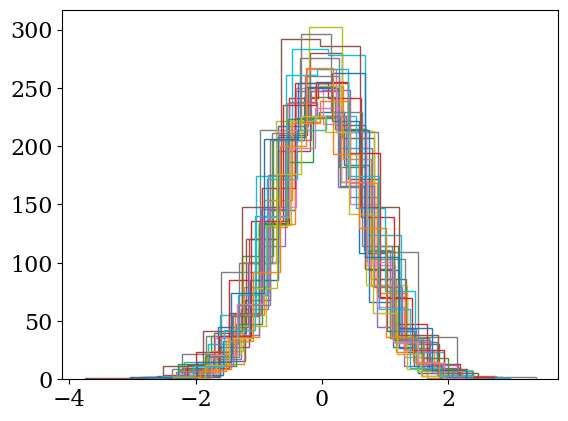

In [43]:
for flux_level_ind,flux_level in enumerate(results_dict):
    y_vals = (results_dict[flux_level]['b_vect_means']-true_b_vect)/results_dict[flux_level]['all_b_vect_errs']
    y_vals[~np.isfinite(results_dict[flux_level]['all_b_vect_errs'])] = np.nan
    for j in range(y_vals.shape[1]):
        if not np.any(np.isfinite(y_vals[:,j])):
            continue
        plt.hist(y_vals[:,j],histtype='step')
    break
# plt.axhline(0,lw=2,ls='--',color='k')

# plt.gca().twinx()
# plt.plot(read_diff_times,true_b_vect,color='k')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc='best')
plt.show()


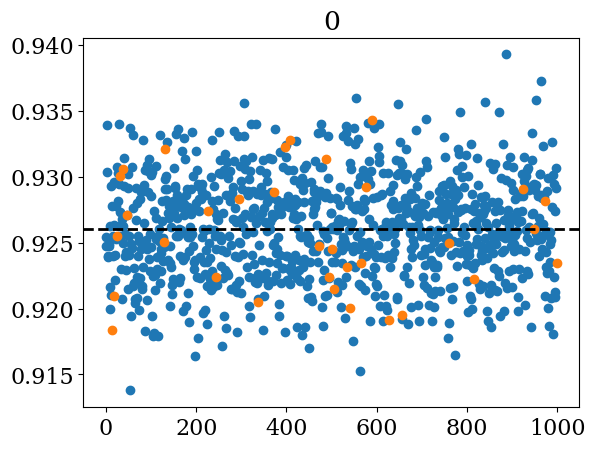

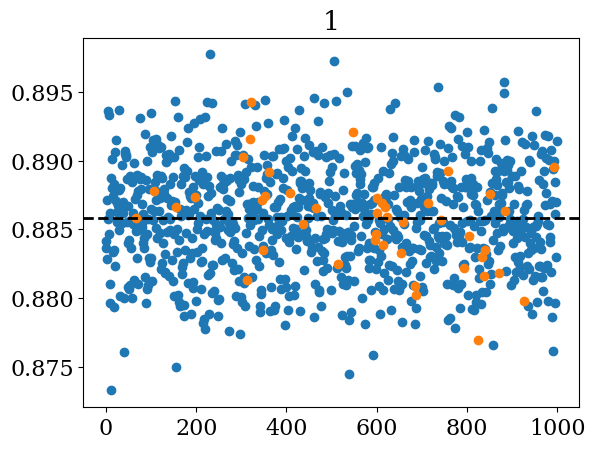

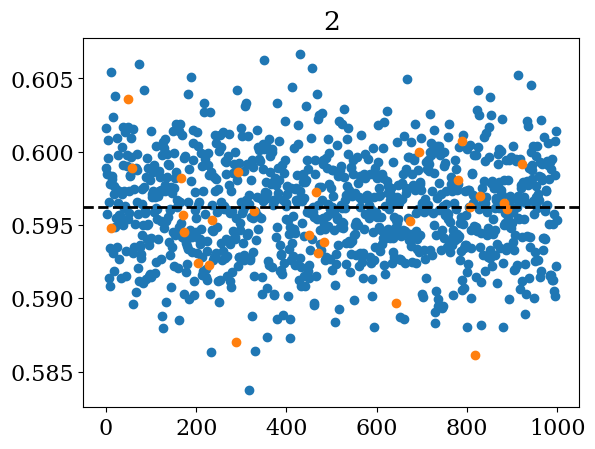

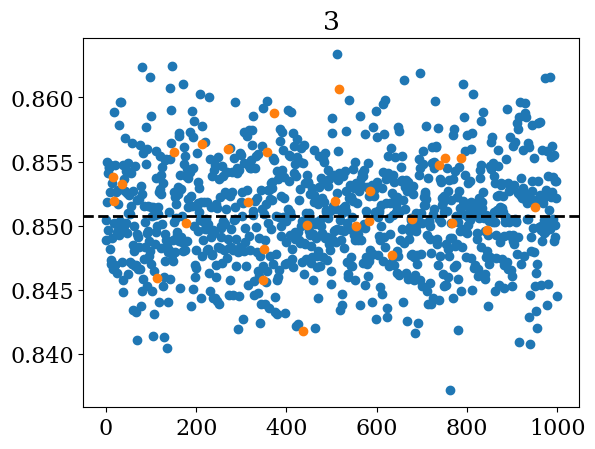

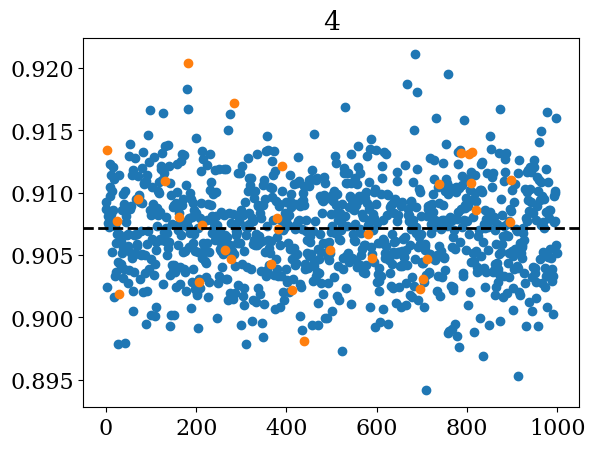

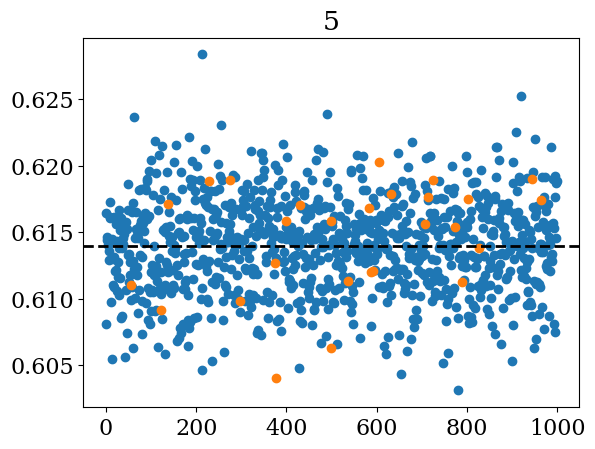

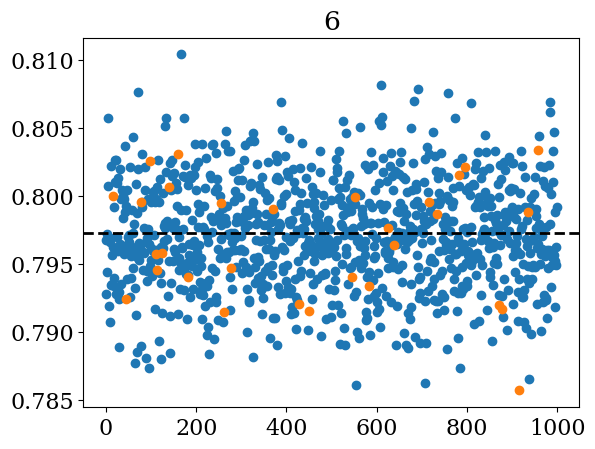

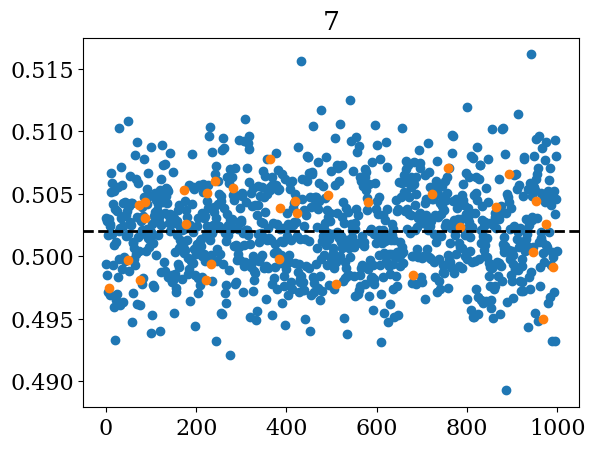

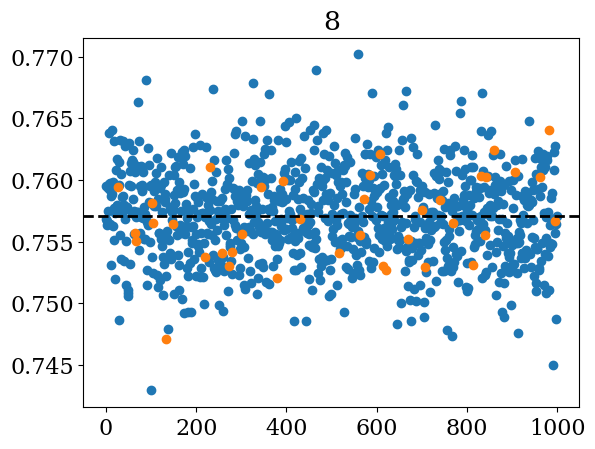

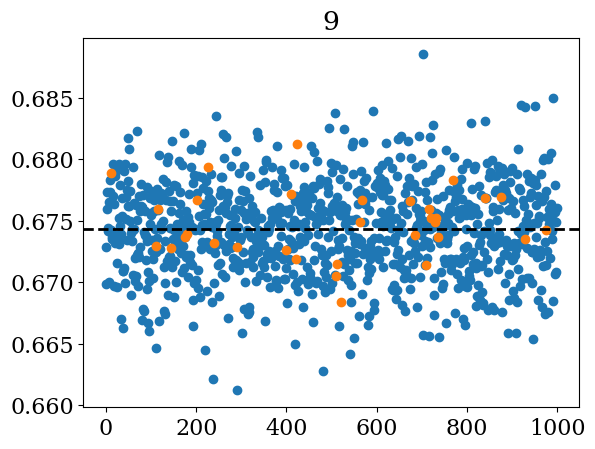

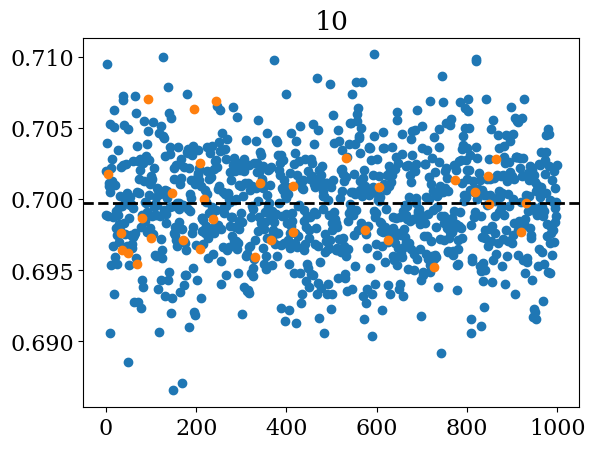

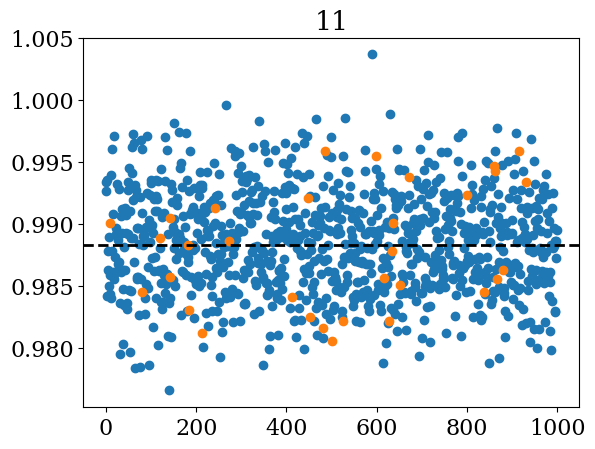

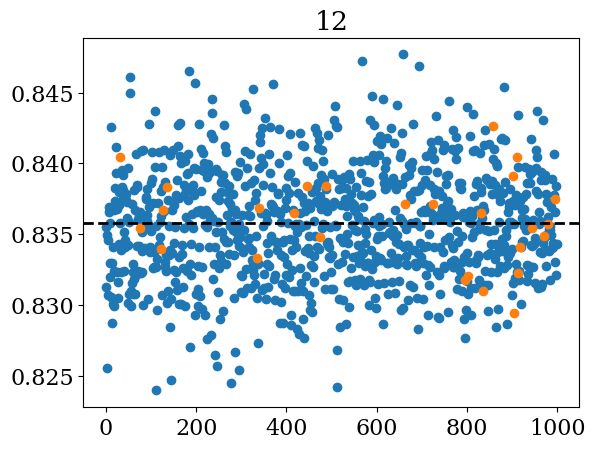

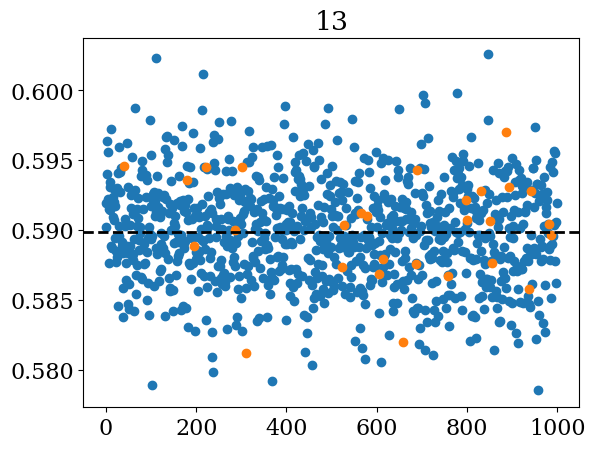

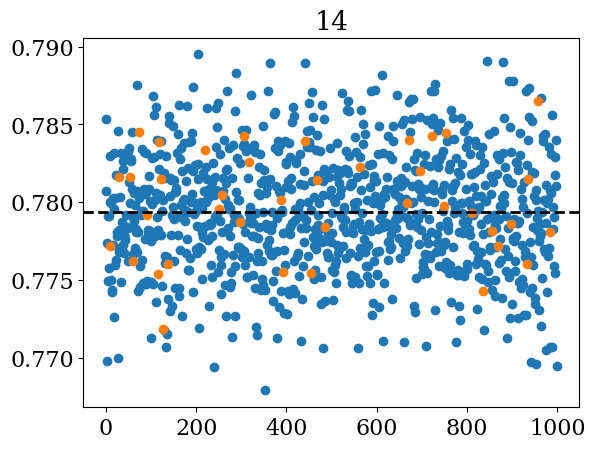

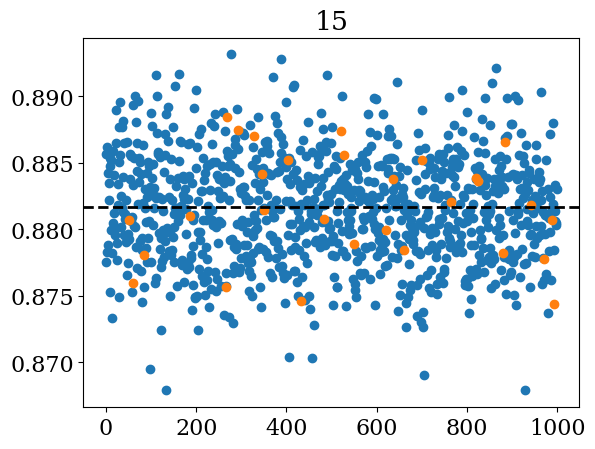

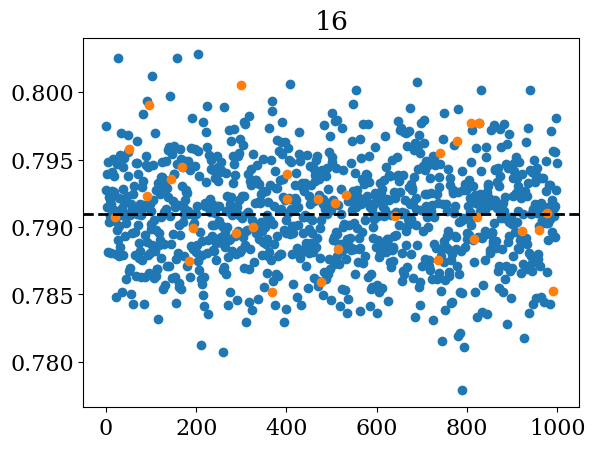

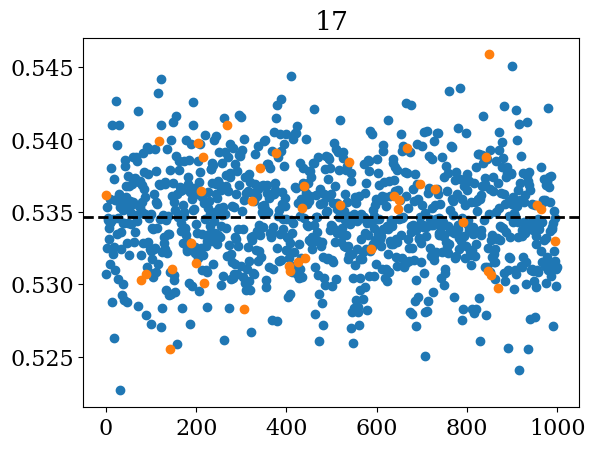

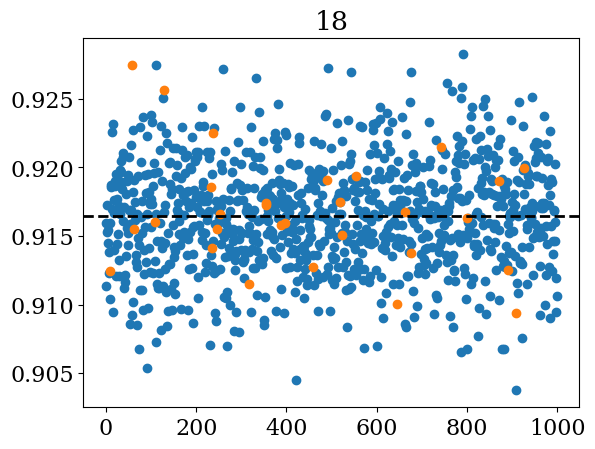

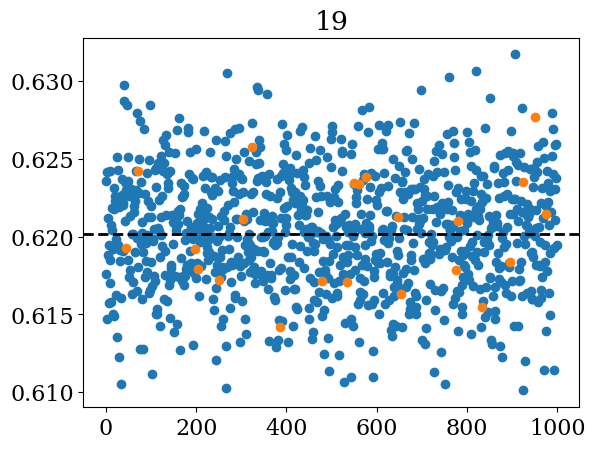

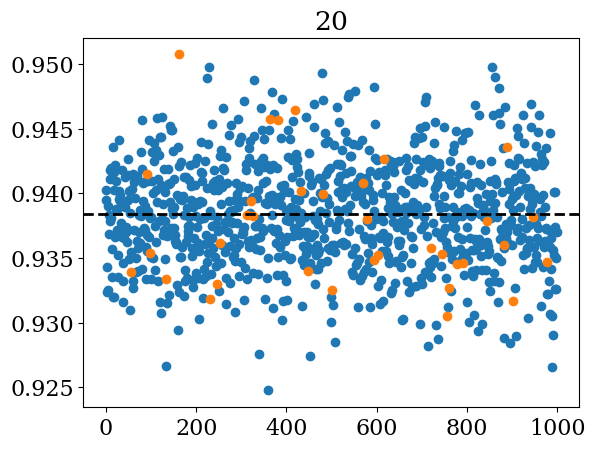

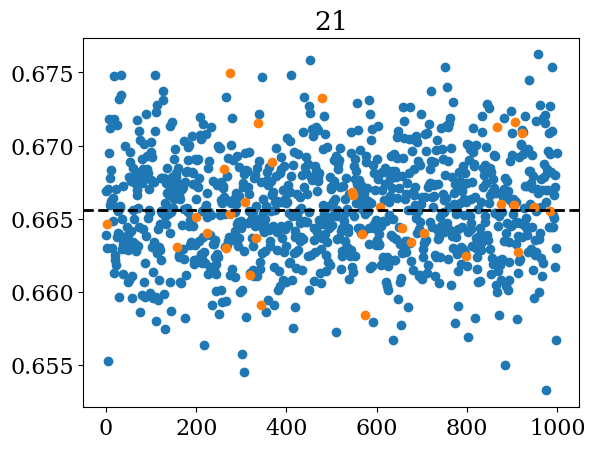

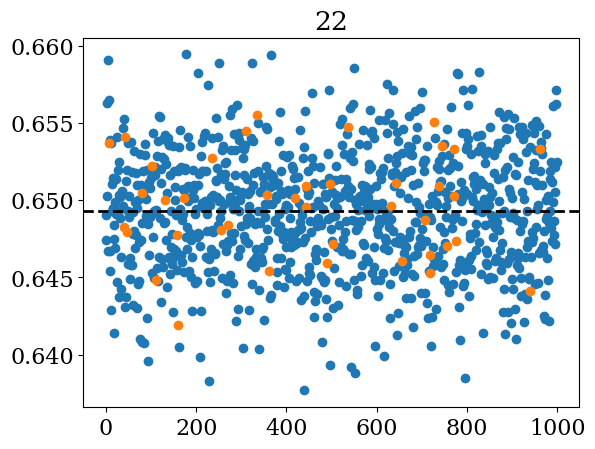

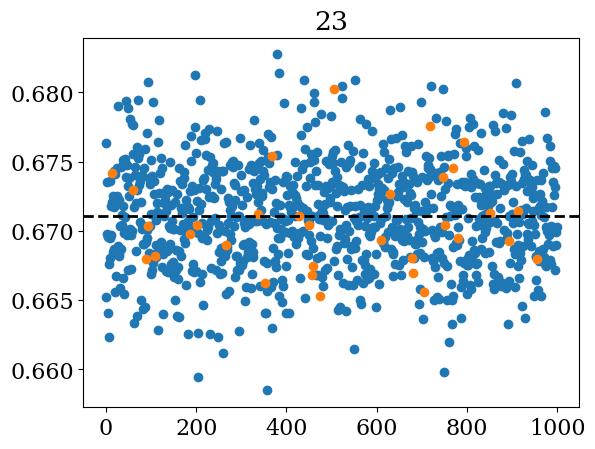

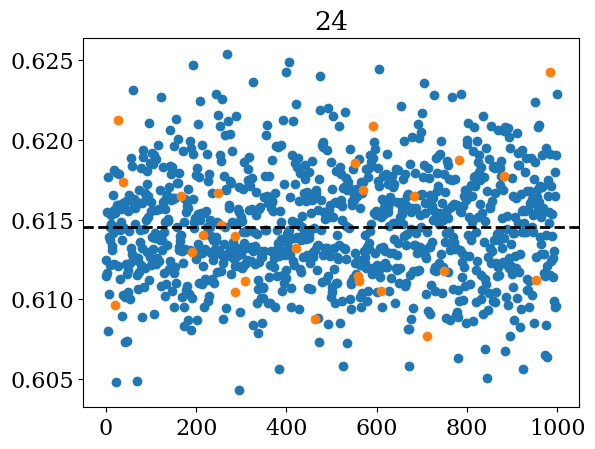

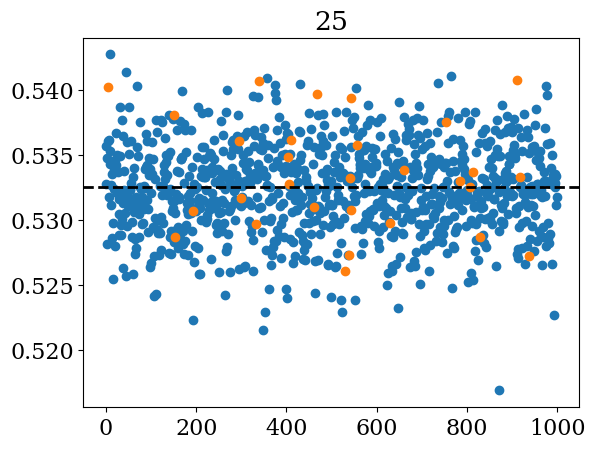

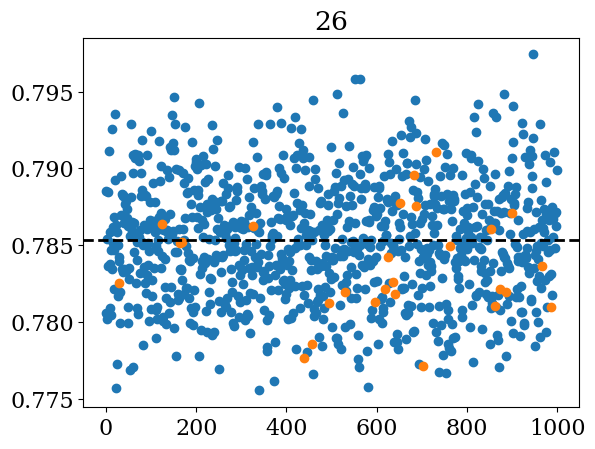

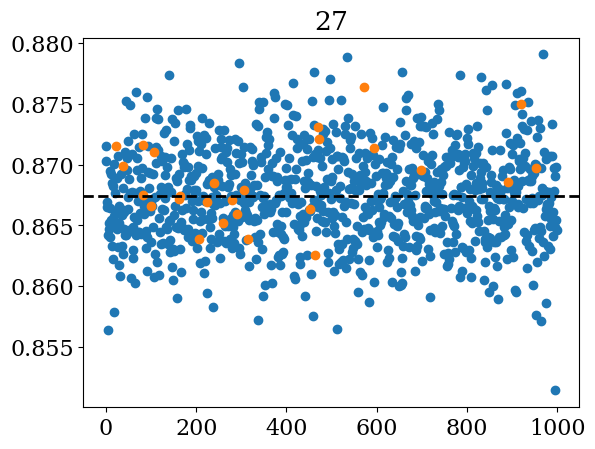

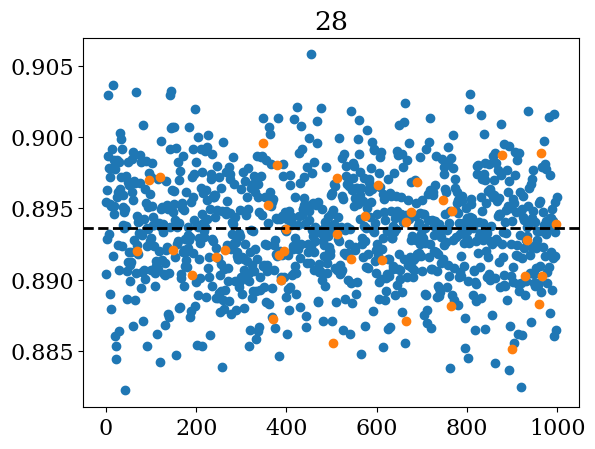

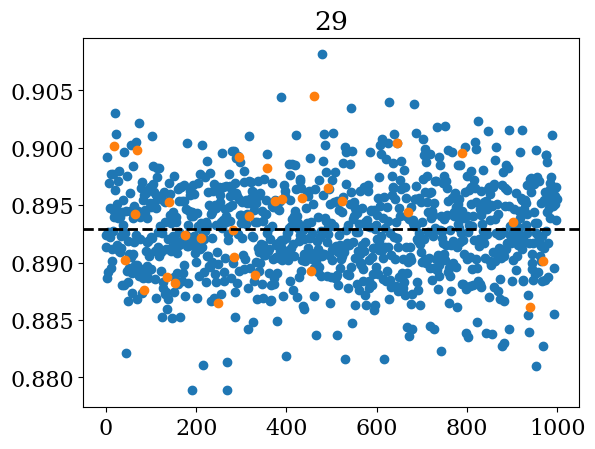

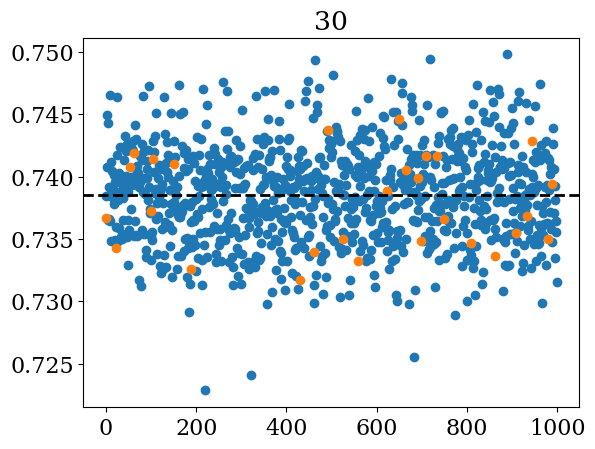

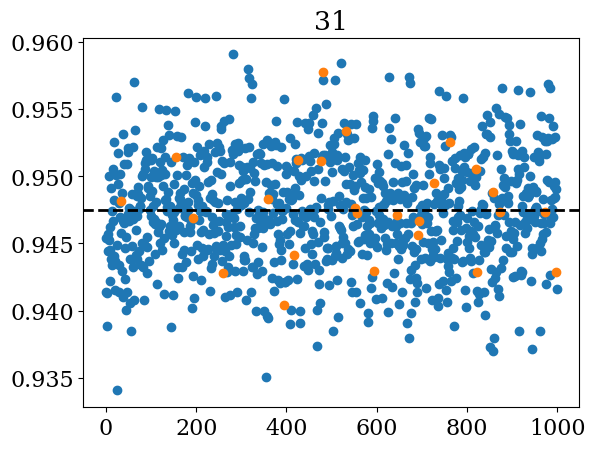

In [45]:
j = np.argmax(true_b_vect)
for j in range(len(true_b_vect)):
    keep = np.isfinite(results_dict[flux_level]['all_b_vect_errs'][:,j])
    plt.scatter(np.arange(len(keep))[keep],results_dict[flux_level]['b_vect_means'][keep,j])
    plt.title(str(j))
    keep = ~np.isfinite(results_dict[flux_level]['all_b_vect_errs'][:,j])
    plt.scatter(np.arange(len(keep))[keep],results_dict[flux_level]['b_vect_means'][keep,j])
    plt.axhline(true_b_vect[j],c='k',lw=2,ls='--')
    plt.show()

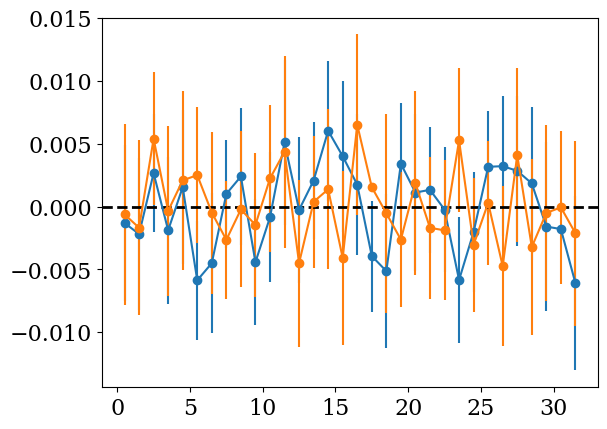

In [47]:
# s_ind = np.where()[0][0]
s_ind = 0

plt.errorbar(read_diff_times,
             results_dict[flux_level]['b_vect_means'][s_ind]-true_b_vect,
            yerr=results_dict[flux_level]['all_b_vect_errs'][s_ind],
            fmt='-o')
s_ind = 1
plt.errorbar(read_diff_times,
             results_dict[flux_level]['b_vect_means'][s_ind]-true_b_vect,
            yerr=results_dict[flux_level]['all_b_vect_errs'][s_ind],
            fmt='-o')
plt.axhline(0.0,c='k',lw=2,ls='--')
plt.show()

In [272]:
used_true_fluxes = np.zeros(len(results_dict))
for ind,key in enumerate(results_dict.keys()):
    used_true_fluxes[ind] = key

cm = matplotlib.cm.viridis_r
norm = matplotlib.colors.LogNorm(vmin=used_true_fluxes.min(),vmax=used_true_fluxes.max())
# create a ScalarMappable and initialize a data structure
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])


/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_45820/3114255985.py:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm,label='True Flux ($e^-$)')


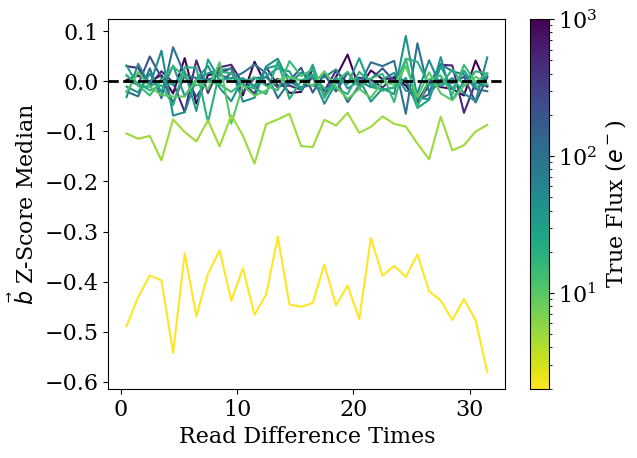

/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_45820/3114255985.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm,label='True Flux ($e^-$)')


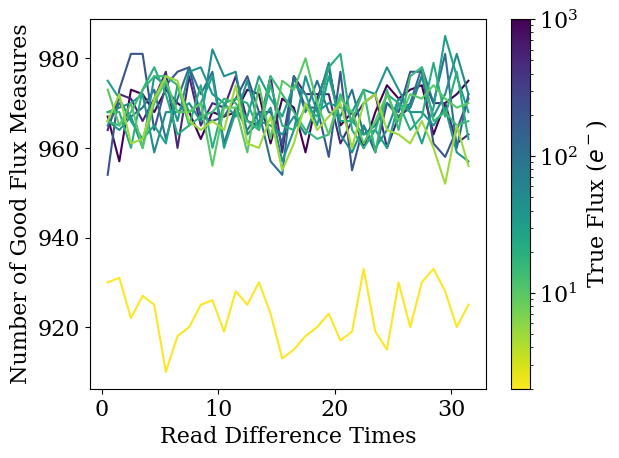

In [275]:
for flux_level_ind,flux_level in enumerate(results_dict):
    color = sm.to_rgba(flux_level)
    y_vals = (results_dict[flux_level]['b_vect_means']-true_b_vect)/results_dict[flux_level]['all_b_vect_errs']
    y_vals[~np.isfinite(results_dict[flux_level]['all_b_vect_errs'])] = np.nan
    plt.plot(read_diff_times,np.nanmedian(y_vals,axis=0),color=color)
plt.colorbar(sm,label='True Flux ($e^-$)')
plt.axhline(0,lw=2,ls='--',color='k')
plt.xlabel('Read Difference Times')
plt.ylabel(r'$\vec b$ Z-Score Median')

# plt.gca().twinx()
# plt.plot(read_diff_times,true_b_vect,color='k')
# # leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# # leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# # leg = plt.legend(loc='best')
plt.show()

for flux_level_ind,flux_level in enumerate(results_dict):
    color = sm.to_rgba(flux_level)
    y_vals = np.sum(np.isfinite(results_dict[flux_level]['all_b_vect_errs']),axis=0)
    plt.plot(read_diff_times,y_vals,color=color)
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc='best')
plt.colorbar(sm,label='True Flux ($e^-$)')
plt.xlabel('Read Difference Times')
plt.ylabel('Number of Good Flux Measures')
plt.show()


/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_45820/1748360581.py:25: RuntimeWarning: All-NaN slice encountered
  med_vals = np.nanmax(b_errs,axis=1)
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_45820/1748360581.py:41: RuntimeWarning: All-NaN slice encountered
  med_vals = np.nanmin(b_errs,axis=1)


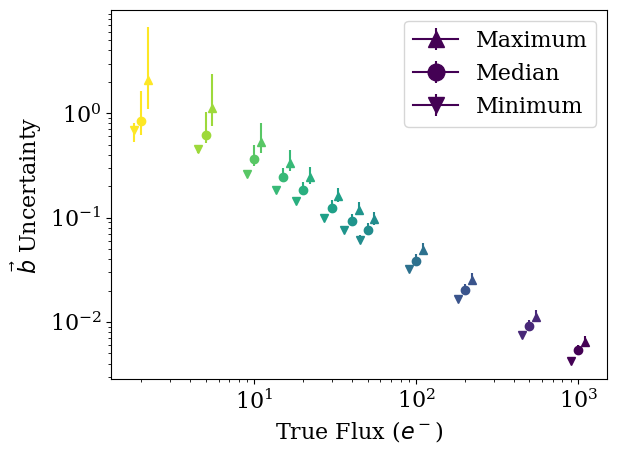

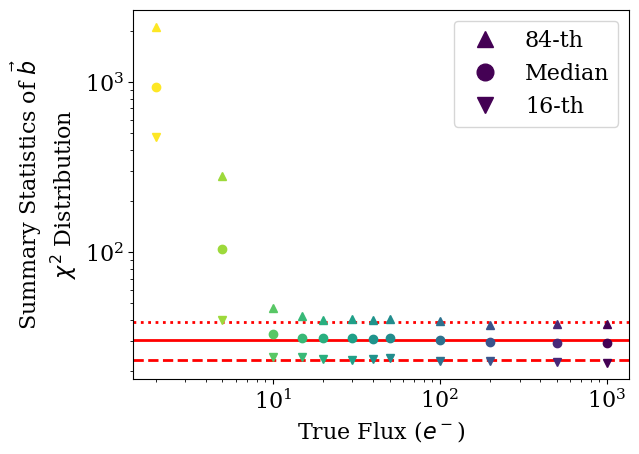

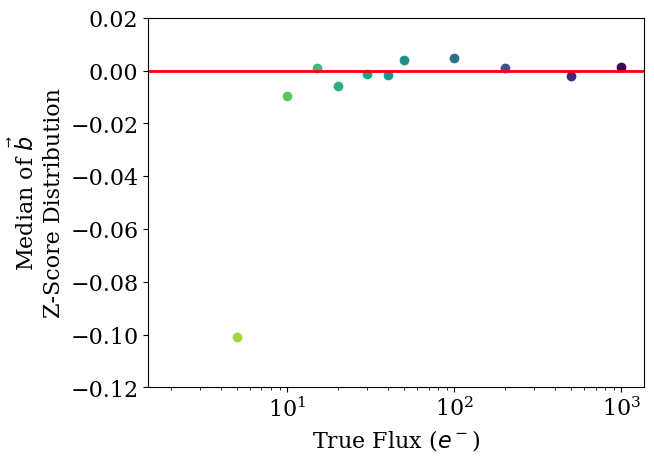

In [284]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
for flux_level_ind,flux_level in enumerate(results_dict):
    # if flux_level < 10:
    #     continue

    b_errs = np.copy(results_dict[flux_level]['all_b_vect_errs'])
    b_errs[~np.isfinite(b_errs)] = np.nan

    if flux_level_ind == 0:
        med_label = 'Median'
        max_label = 'Maximum'
        min_label = 'Minimum'
    else:
        med_label = ''
        max_label = ''
        min_label = ''
    
    color = sm.to_rgba(flux_level)

    marker = '^'
    offset = 1.1
    med_vals = np.nanmax(b_errs,axis=1)
    med_val = np.nanmedian(med_vals)
    err_vals = (np.abs(np.nanpercentile(med_vals,[16,84])-med_val)).reshape((-1,1))
    plt.errorbar(flux_level*offset,med_val,yerr=err_vals,
                 color=color,marker=marker,label=max_label)

    marker = 'o'
    offset = 1.0
    med_vals = np.nanmedian(b_errs,axis=1)
    med_val = np.nanmedian(med_vals)
    err_vals = (np.abs(np.nanpercentile(med_vals,[16,84])-med_val)).reshape((-1,1))
    plt.errorbar(flux_level*offset,med_val,yerr=err_vals,
                 color=color,marker=marker,label=med_label)

    marker = 'v'
    offset = 0.9
    med_vals = np.nanmin(b_errs,axis=1)
    med_val = np.nanmedian(med_vals)
    err_vals = (np.abs(np.nanpercentile(med_vals,[16,84])-med_val)).reshape((-1,1))
    plt.errorbar(flux_level*offset,med_val,yerr=err_vals,
                 color=color,marker=marker,label=min_label)

leg = plt.legend(loc='best',markerscale=2)
plt.xlabel(r'True Flux ($e^-$)')
plt.ylabel(r'$\vec b$ Uncertainty')
plt.show()

plt.figure()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
b_vect_inflate_factors = np.zeros(len(results_dict))
for flux_level_ind,flux_level in enumerate(results_dict):
    color = sm.to_rgba(flux_level)

    if flux_level_ind == 0:
        med_label = 'Median'
        max_label = '84-th'
        min_label = '16-th'
    else:
        med_label = ''
        max_label = ''
        min_label = ''

    y_vals = np.copy(results_dict[flux_level]['all_b_vect_chi2s'])
    y_vals[~np.isfinite(y_vals)] = np.nan
    plt.errorbar(flux_level,np.nanpercentile(y_vals,84),color=color,fmt='^',label=max_label)
    plt.errorbar(flux_level,np.nanmedian(y_vals),color=color,fmt='o',label=med_label)
    plt.errorbar(flux_level,np.nanpercentile(y_vals,16),color=color,fmt='v',label=min_label)

    b_vect_inflate_factors[flux_level_ind] = stats.chi2.fit(y_vals[np.isfinite(y_vals)],fdf=n_reads-2,floc=0)[2]**0.5
expect_dist = stats.chi2(df=n_reads-2)
plt.axhline(expect_dist.ppf(0.16),c='r',lw=2,ls='--')
plt.axhline(expect_dist.ppf(0.5),c='r',lw=2,ls='-')
plt.axhline(expect_dist.ppf(0.84),c='r',lw=2,ls=':')
plt.xlabel(r'True Flux ($e^-$)')
plt.ylabel(r'Summary Statistics of $\vec b$'+'\n'+r'$\chi^2$ Distribution')
leg = plt.legend(loc='best',markerscale=2)
# ax1 = ax.twinx()
# ax1.set_yscale('log')
# plt.plot(list(results_dict.keys()),b_vect_inflate_factors,color='k')
# plt.ylabel(r'$\vec b$ Uncertainty Inflation Factor')
# ax1.set_ylim(0.9,10)

plt.show()

plt.figure()
ax = plt.gca()
ax.set_xscale('log')
# ax.set_yscale('log')
for flux_level_ind,flux_level in enumerate(results_dict):
    color = sm.to_rgba(flux_level)

    y_vals = (results_dict[flux_level]['b_vect_means']-true_b_vect)/results_dict[flux_level]['all_b_vect_errs']
    y_vals[~np.isfinite(results_dict[flux_level]['all_b_vect_errs'])] = np.nan

    med_vals = np.nanmedian(y_vals,axis=0)
    up_vals = np.nanpercentile(y_vals,84,axis=0)
    down_vals = np.nanpercentile(y_vals,16,axis=0)

    plt.scatter(flux_level,np.nanmedian(med_vals),color=color,marker='o')
    # plt.errorbar(flux_level,np.nanmedian(up_vals),color=color,fmt='v')
    # plt.errorbar(flux_level,np.nanmedian(down_vals),color=color,fmt='^')
plt.ylim(-0.12,0.02)
expect_dist = stats.norm(loc=0,scale=1)
# plt.axhline(expect_dist.ppf(0.16),c='r',lw=2,ls='--')
plt.axhline(expect_dist.ppf(0.5),c='r',lw=2,ls='-')
# plt.axhline(expect_dist.ppf(0.84),c='r',lw=2,ls=':')
plt.xlabel(r'True Flux ($e^-$)')
plt.ylabel(r'Median of $\vec b$'+'\n'+r'Z-Score Distribution')
plt.show()




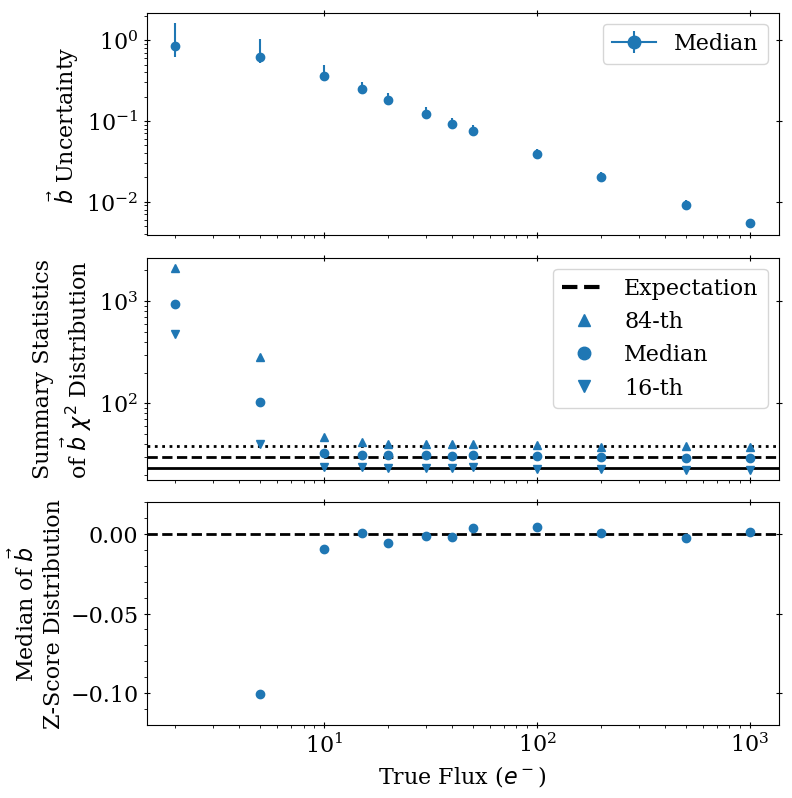

In [319]:
s = 10


# plt.figure(figsize=(10,5))
# ax = plt.gca()
plt.figure(figsize=(8,8))
# gs = gridspec.GridSpec(3,2,hspace=0.1, wspace=0.04, width_ratios=[1,0.03],
#                        left=0.16, right=0.9, top=0.98, bottom = 0.08)
gs = gridspec.GridSpec(3,1,hspace=0.1, wspace=0.04,
                       left=0.18, right=0.97, top=0.97, bottom = 0.08)

ax = plt.subplot(gs[0,0])   
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

ax.set_xscale('log')
ax.set_yscale('log')
for flux_level_ind,flux_level in enumerate(results_dict):
    # if flux_level < 10:
    #     continue

    b_errs = np.copy(results_dict[flux_level]['all_b_vect_errs'])
    b_errs[~np.isfinite(b_errs)] = np.nan

    if flux_level_ind == 0:
        med_label = 'Median'
        max_label = 'Maximum'
        min_label = 'Minimum'
    else:
        med_label = ''
        max_label = ''
        min_label = ''
    
    color = sm.to_rgba(flux_level)
    color = 'C0'

    # marker = '^'
    # offset = 1.1
    # med_vals = np.nanmax(b_errs,axis=1)
    # med_val = np.nanmedian(med_vals)
    # err_vals = (np.abs(np.nanpercentile(med_vals,[16,84])-med_val)).reshape((-1,1))
    # plt.errorbar(flux_level*offset,med_val,yerr=err_vals,
    #              color=color,marker=marker,label=max_label)

    marker = 'o'
    offset = 1.0
    med_vals = np.nanmedian(b_errs,axis=1)
    med_val = np.nanmedian(med_vals)
    err_vals = (np.abs(np.nanpercentile(med_vals,[16,84])-med_val)).reshape((-1,1))
    plt.errorbar(flux_level*offset,med_val,yerr=err_vals,
                 color=color,marker=marker,label=med_label)

    # marker = 'v'
    # offset = 0.9
    # med_vals = np.nanmin(b_errs,axis=1)
    # med_val = np.nanmedian(med_vals)
    # err_vals = (np.abs(np.nanpercentile(med_vals,[16,84])-med_val)).reshape((-1,1))
    # plt.errorbar(flux_level*offset,med_val,yerr=err_vals,
    #              color=color,marker=marker,label=min_label)

leg = plt.legend(loc='best',markerscale=1.5)
# plt.xlabel(r'True Flux ($e^-$)')
ax.set_xticklabels([])
plt.ylabel(r'$\vec b$ Uncertainty')


ax = plt.subplot(gs[1,0])   
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

ax.set_xscale('log')
ax.set_yscale('log')
b_vect_inflate_factors = np.zeros(len(results_dict))
for flux_level_ind,flux_level in enumerate(results_dict):
    color = sm.to_rgba(flux_level)
    color = 'C0'

    if flux_level_ind == 0:
        med_label = 'Median'
        max_label = '84-th'
        min_label = '16-th'
    else:
        med_label = ''
        max_label = ''
        min_label = ''

    y_vals = np.copy(results_dict[flux_level]['all_b_vect_chi2s'])
    y_vals[~np.isfinite(y_vals)] = np.nan
    plt.errorbar(flux_level,np.nanpercentile(y_vals,84),color=color,fmt='^',label=max_label)
    plt.errorbar(flux_level,np.nanmedian(y_vals),color=color,fmt='o',label=med_label)
    plt.errorbar(flux_level,np.nanpercentile(y_vals,16),color=color,fmt='v',label=min_label)

    b_vect_inflate_factors[flux_level_ind] = stats.chi2.fit(y_vals[np.isfinite(y_vals)],fdf=n_reads-2,floc=0)[2]**0.5
expect_dist = stats.chi2(df=n_reads-2)
plt.axhline(expect_dist.ppf(0.16),c='k',lw=2,ls='-')
plt.axhline(expect_dist.ppf(0.5),c='k',lw=2,ls='--',label='Expectation')
plt.axhline(expect_dist.ppf(0.84),c='k',lw=2,ls=':')
# plt.xlabel(r'True Flux ($e^-$)')
plt.ylabel(r'Summary Statistics'+'\n'+r'of $\vec b$ $\chi^2$ Distribution')
leg = plt.legend(loc='best',markerscale=1.5)
for line in leg.get_lines():
    line.set_linewidth(3)
# ax1 = ax.twinx()
# ax1.set_yscale('log')
# plt.plot(list(results_dict.keys()),b_vect_inflate_factors,color='k')
# plt.ylabel(r'$\vec b$ Uncertainty Inflation Factor')
# ax1.set_ylim(0.9,10)
ax.set_xticklabels([])

ax = plt.subplot(gs[2,0])   
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
for flux_level_ind,flux_level in enumerate(results_dict):
    color = sm.to_rgba(flux_level)
    color = 'C0'

    y_vals = (results_dict[flux_level]['b_vect_means']-true_b_vect)/results_dict[flux_level]['all_b_vect_errs']
    y_vals[~np.isfinite(results_dict[flux_level]['all_b_vect_errs'])] = np.nan

    med_vals = np.nanmedian(y_vals,axis=0)
    up_vals = np.nanpercentile(y_vals,84,axis=0)
    down_vals = np.nanpercentile(y_vals,16,axis=0)

    plt.errorbar(flux_level,np.nanmedian(med_vals),color=color,marker='o')
    # plt.errorbar(flux_level,np.nanmedian(up_vals),color=color,fmt='v')
    # plt.errorbar(flux_level,np.nanmedian(down_vals),color=color,fmt='^')
plt.ylim(-0.12,0.02)
expect_dist = stats.norm(loc=0,scale=1)
# plt.axhline(expect_dist.ppf(0.16),c='k',lw=2,ls='--')
plt.axhline(expect_dist.ppf(0.5),c='k',lw=2,ls='--',label='Expectation')
# plt.axhline(expect_dist.ppf(0.84),c='k',lw=2,ls=':')
plt.xlabel(r'True Flux ($e^-$)')
plt.ylabel(r'Median of $\vec b$'+'\n'+r'Z-Score Distribution')

# plt.colorbar(sm,ax=ax,cax=plt.subplot(gs[:,1]),label=r'True Flux ($e^{-}$)')

plt.savefig(f'{plotpath}repeat_flux_fit_b_vects.png')
plt.show()




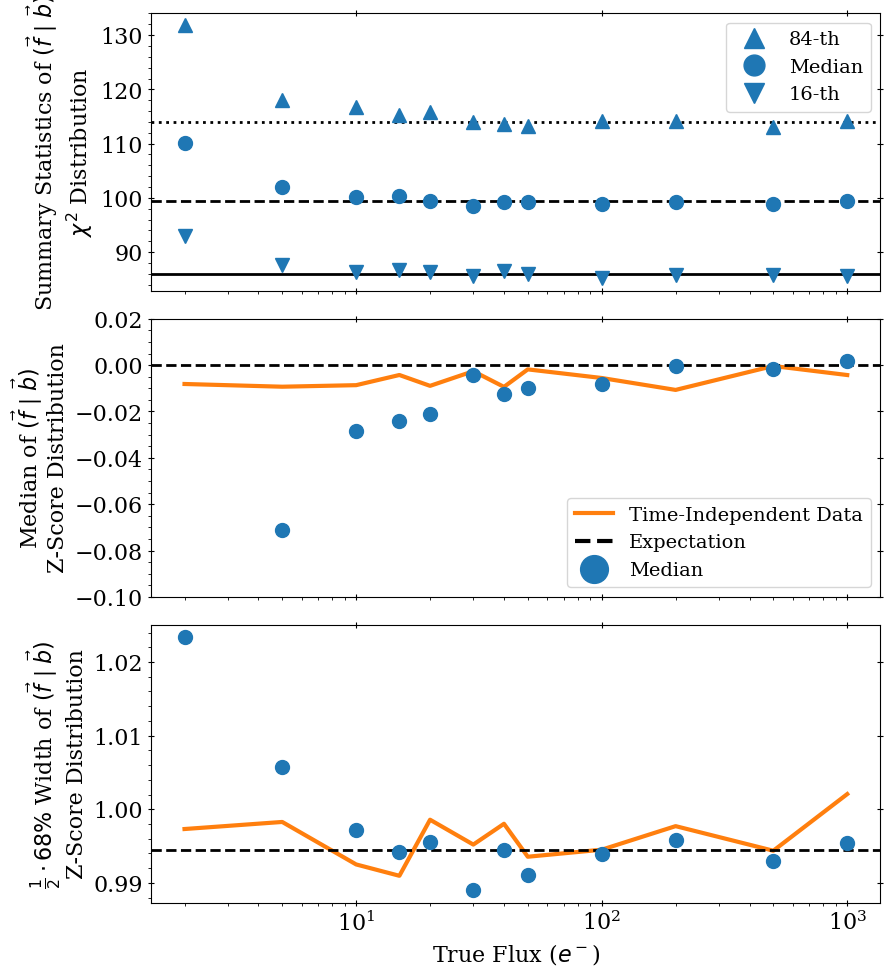

In [317]:
s = 10


# plt.figure(figsize=(10,5))
# ax = plt.gca()
plt.figure(figsize=(9,10))
# gs = gridspec.GridSpec(3,2,hspace=0.1, wspace=0.04, width_ratios=[1,0.03],
#                        left=0.16, right=0.9, top=0.98, bottom = 0.08)
gs = gridspec.GridSpec(3,1,hspace=0.1, wspace=0.04,
                       left=0.16, right=0.97, top=0.97, bottom = 0.08)

ax = plt.subplot(gs[0,0])   
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

flux_inflate_factors = np.zeros(len(results_dict))
for flux_level_ind,flux_level in enumerate(results_dict):
    color = sm.to_rgba(flux_level)
    color = 'C0'
    if flux_level_ind == 0:
        med_label = 'Median'
        max_label = '84-th'
        min_label = '16-th'
    else:
        med_label = ''
        max_label = ''
        min_label = ''


    y_vals = np.copy(results_dict[flux_level]['all_f_given_b_chi2s_with_bs'])
    y_vals[~np.isfinite(y_vals)] = np.nan
    plt.errorbar(flux_level,np.nanpercentile(y_vals,84),color=color,fmt='^',label=max_label,ms=s)
    plt.errorbar(flux_level,np.nanmedian(y_vals),color=color,fmt='o',label=med_label,ms=s)
    plt.errorbar(flux_level,np.nanpercentile(y_vals,16),color=color,fmt='v',label=min_label,ms=s)

    flux_inflate_factors[flux_level_ind] = stats.chi2.fit(y_vals[np.isfinite(y_vals)],fdf=n_pixels,floc=0)[2]**0.5
expect_dist = stats.chi2(df=n_pixels)
plt.axhline(expect_dist.ppf(0.16),c='k',lw=2,ls='-')
plt.axhline(expect_dist.ppf(0.5),c='k',lw=2,ls='--')
plt.axhline(expect_dist.ppf(0.84),c='k',lw=2,ls=':')
# plt.xlabel(r'True Flux ($e^-$)')
leg = plt.legend(loc='best',markerscale=1.5,fontsize=14)
ax.set_xticklabels([])
plt.ylabel(r'Summary Statistics of $(\vec f \mid \vec b)$'+'\n'+r'$\chi^2$ Distribution')
# ax1 = ax.twinx()
# ax1.set_yscale('log')
# plt.plot(list(results_dict.keys()),flux_inflate_factors,color='k')
# plt.ylabel(r'$(\vec f \mid \vec b)$ Uncertainty Inflation Factor')
# ax1.set_ylim(0.9,10)




ax = plt.subplot(gs[1,0])   
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)

# ax.set_yscale('log')
for flux_level_ind,flux_level in enumerate(results_dict):
    color = sm.to_rgba(flux_level)
    color = 'C0'

    y_vals = np.copy(results_dict[flux_level]['all_f_given_b_zscores_with_bs'])
    y_vals[~np.isfinite(y_vals)] = np.nan

    med_vals = np.nanmedian(y_vals,axis=1)
    up_vals = np.nanpercentile(y_vals,84,axis=0)
    down_vals = np.nanpercentile(y_vals,16,axis=0)
    if flux_level_ind == 0:
        label = 'Median'
    else:
        label = ''

    plt.errorbar(flux_level,np.nanmedian(y_vals),color=color,fmt='o',label=label,ms=s)
    # plt.errorbar(flux_level,np.nanmedian(med_vals),yerr=np.nanstd(med_vals),color=color,fmt='o')
    # plt.errorbar(flux_level,np.nanmedian(up_vals),color=color,fmt='v')
    # plt.errorbar(flux_level,np.nanmedian(down_vals),color=color,fmt='^')

time_indep_comp = np.zeros(len(results_dict))
for flux_level_ind,flux_level in enumerate(results_dict):
    y_vals = np.copy(time_indep_results_dict[flux_level]['all_f_given_b_zscores_no_bs'])
    y_vals[~np.isfinite(y_vals)] = np.nan
    time_indep_comp[flux_level_ind] = np.nanmedian(y_vals)
plt.plot(results_dict.keys(),time_indep_comp,color='C1',label='Time-Independent Data',lw=3)
plt.ylim(-0.10,0.02)
expect_dist = stats.norm(loc=0,scale=1)
# plt.axhline(expect_dist.ppf(0.16),c='k',lw=2,ls='--')
plt.axhline(expect_dist.ppf(0.5),c='k',lw=2,ls='--',label='Expectation')
# plt.axhline(expect_dist.ppf(0.84),c='k',lw=2,ls=':')
# plt.xlabel(r'True Flux ($e^-$)')
ax.set_xticklabels([])
plt.ylabel(r'Median of $(\vec f \mid \vec b)$'+'\n'+r'Z-Score Distribution')
leg = plt.legend(loc='best',markerscale=2,fontsize=14)
for line in leg.get_lines():
    line.set_linewidth(3)
# plt.show()

ax = plt.subplot(gs[2,0])   
ax.set_xscale('log')
plt.minorticks_on()
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
# ax.set_yscale('log')
for flux_level_ind,flux_level in enumerate(results_dict):
    color = sm.to_rgba(flux_level)
    color = 'C0'

    y_vals = np.copy(results_dict[flux_level]['all_f_given_b_zscores_with_bs'])
    y_vals[~np.isfinite(y_vals)] = np.nan

    med_vals = np.nanmedian(y_vals,axis=1)
    up_vals = np.nanpercentile(y_vals,84,axis=0)
    down_vals = np.nanpercentile(y_vals,16,axis=0)

    if flux_level_ind == 0:
        label = 'Median'
    else:
        label = ''
    plt.errorbar(flux_level,0.5*np.diff(np.nanpercentile(y_vals,[16,84]))[0],color=color,fmt='o',label=label,ms=s)
    # plt.errorbar(flux_level,np.nanmedian(med_vals),yerr=np.nanstd(med_vals),color=color,fmt='o')
    # plt.errorbar(flux_level,np.nanmedian(up_vals),color=color,fmt='v')
    # plt.errorbar(flux_level,np.nanmedian(down_vals),color=color,fmt='^')

time_indep_comp = np.zeros(len(results_dict))
for flux_level_ind,flux_level in enumerate(results_dict):
    y_vals = np.copy(time_indep_results_dict[flux_level]['all_f_given_b_zscores_no_bs'])
    y_vals[~np.isfinite(y_vals)] = np.nan
    time_indep_comp[flux_level_ind] = 0.5*np.diff(np.nanpercentile(y_vals,[16,84]))[0]
plt.plot(results_dict.keys(),time_indep_comp,color='C1',label='Time-Indepedent Data',lw=3)
# plt.ylim(-0.10,0.02)
expect_dist = stats.norm(loc=0,scale=1)
plt.axhline(0.5*(expect_dist.ppf(0.84)-expect_dist.ppf(0.16)),c='k',lw=2,ls='--',label='Expectation')
# plt.axhline(expect_dist.ppf(0.5),c='r',lw=2,ls='-')
# plt.axhline(expect_dist.ppf(0.84),c='r',lw=2,ls=':')
# leg = plt.legend(loc='best',markerscale=2,fontsize=14)
# for line in leg.get_lines():
#     line.set_linewidth(3)
plt.xlabel(r'True Flux ($e^-$)')
plt.ylabel(r'$\frac{1}{2}\cdot 68\%$ Width of $(\vec f \mid \vec b)$'+'\n'+r'Z-Score Distribution')

# plt.colorbar(sm,ax=ax,cax=plt.subplot(gs[:,1]),label=r'True Flux ($e^{-}$)')

plt.savefig(f'{plotpath}repeat_flux_fit_fluxes.png')
plt.show()




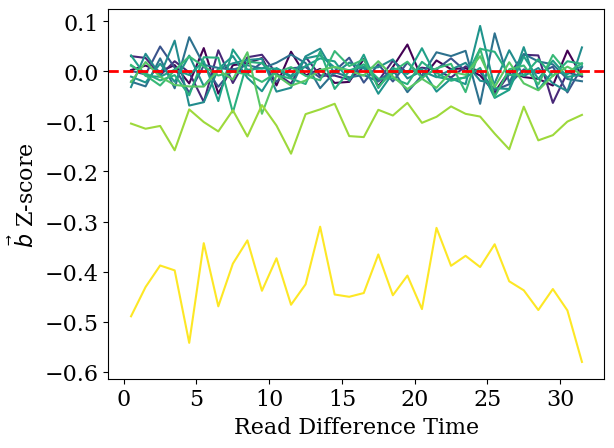

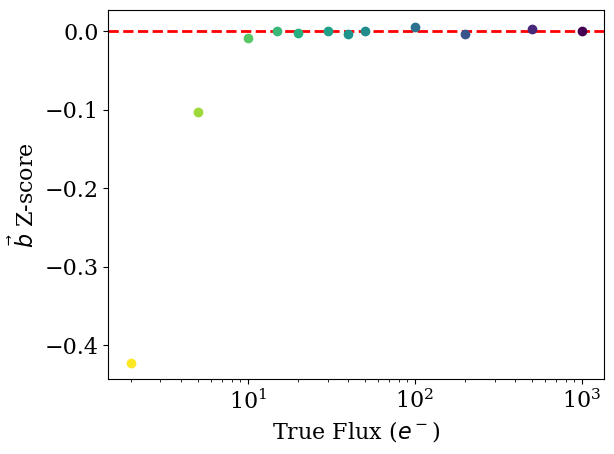

In [133]:

plt.figure()
ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
for flux_level_ind,flux_level in enumerate(results_dict):
    color = sm.to_rgba(flux_level)

    y_vals = (results_dict[flux_level]['b_vect_means']-true_b_vect)/results_dict[flux_level]['all_b_vect_errs']
    y_vals[~np.isfinite(results_dict[flux_level]['all_b_vect_errs'])] = np.nan
    plt.plot(read_diff_times,np.nanmedian(y_vals,axis=0),color=color)

plt.axhline(c='r',lw=2,ls='--')
plt.xlabel(r'Read Difference Time')
plt.ylabel(r'$\vec b$ Z-score')
plt.show()


plt.figure()
ax = plt.gca()
ax.set_xscale('log')
# ax.set_yscale('log')
for flux_level_ind,flux_level in enumerate(results_dict):
    color = sm.to_rgba(flux_level)
    

    y_vals = (results_dict[flux_level]['b_vect_means']-true_b_vect)/results_dict[flux_level]['all_b_vect_errs']
    y_vals[~np.isfinite(results_dict[flux_level]['all_b_vect_errs'])] = np.nan
    plt.errorbar(flux_level,np.nanmedian(y_vals),color=color,fmt='o')

plt.axhline(c='r',lw=2,ls='--')
plt.xlabel(r'True Flux ($e^-$)')
plt.ylabel(r'$\vec b$ Z-score')
plt.show()

# plt.figure()
# ax = plt.gca()
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# for flux_level_ind,flux_level in enumerate(results_dict):
#     color = sm.to_rgba(flux_level)

#     y_vals = (results_dict[flux_level]['b_vect_means']-true_b_vect)/results_dict[flux_level]['all_b_vect_errs']
#     y_vals[~np.isfinite(results_dict[flux_level]['all_b_vect_errs'])] = np.nan
#     y_widths = 
#     plt.plot(read_diff_times,np.nanmedian(y_vals,axis=0),color=color)

# plt.axhline(c='r',lw=2,ls='--')
# plt.xlabel(r'Read Difference Time')
# plt.ylabel(r'$\vec b$ Z-score')
# plt.show()



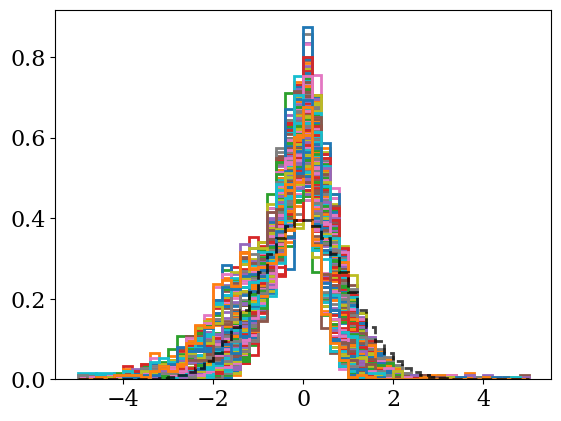

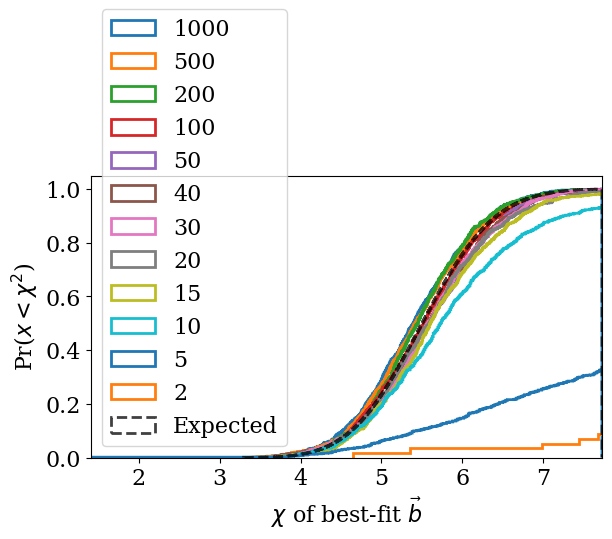

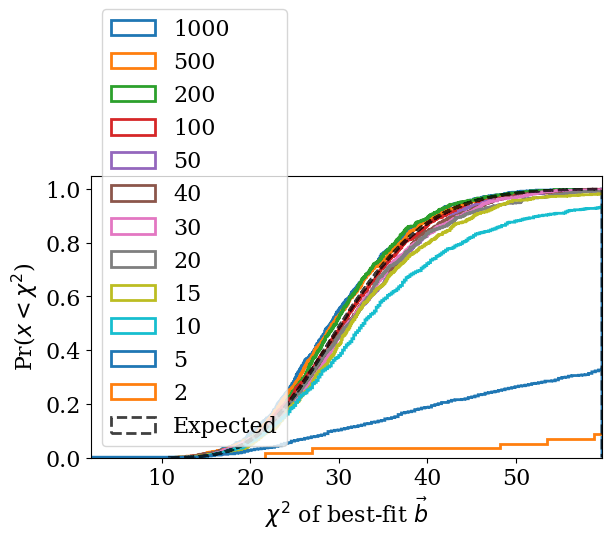

In [49]:

for flux_level_ind,flux_level in enumerate(results_dict):
    all_b_vect_zscores = results_dict[flux_level]['all_b_vect_zscores']
    for j in range(all_b_vect_zscores.shape[1]):
        hist = plt.hist(np.ravel(all_b_vect_zscores[:,j]),
                        histtype='step',cumulative=False,
                        density=True,bins=50,range=[-5,5],
                        label=flux_level,lw=lw,alpha=alpha)

hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
expect_weights = np.diff(stats.norm(loc=0,scale=1).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=False,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc='best')
plt.show()



for flux_level_ind,flux_level in enumerate(results_dict):
    all_b_vect_chi2s = results_dict[flux_level]['all_b_vect_chi2s']
    keep = (all_b_vect_chi2s > 0) & (all_b_vect_chi2s < n_reads*10)
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_b_vect_chi2s[keep])),
                        histtype='step',cumulative=cumulative,
                        density=True,bins=np.size(all_b_vect_chi2s[keep]),
                        label=flux_level,lw=lw,alpha=alpha)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
        xlim = np.array([hist_bins[0],hist_bins[-1]])
        
    else:
        curr_hist = plt.hist(np.sqrt(np.ravel(all_b_vect_chi2s[keep])),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_b_vect_chi2s[keep]),
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=flux_level,lw=lw,alpha=alpha)
        xlim[0] = min(xlim[0],curr_hist[1][0])
plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
leg = plt.legend(loc='best')
plt.xlabel(r'$\chi$ of best-fit $\vec b$')
plt.ylabel(r'Pr($x < \chi^2$)')
plt.tight_layout()
plt.savefig(f'{plotpath}repeat_bvect_chi.png')
plt.show()


for flux_level_ind,flux_level in enumerate(results_dict):
    all_b_vect_chi2s = results_dict[flux_level]['all_b_vect_chi2s']
    keep = (all_b_vect_chi2s > 0) & (all_b_vect_chi2s < n_reads*10)
    if flux_level_ind == 0:
        hist = plt.hist(np.ravel(all_b_vect_chi2s[keep]),
                        histtype='step',cumulative=cumulative,
                        density=True,bins=np.size(all_b_vect_chi2s[keep]),
                        label=flux_level,lw=lw,alpha=alpha)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
        xlim = np.array([hist_bins[0],hist_bins[-1]])
        
    else:
        curr_hist = plt.hist(np.ravel(all_b_vect_chi2s[keep]),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_b_vect_chi2s[keep]),
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=flux_level,lw=lw,alpha=alpha)
        xlim[0] = min(xlim[0],curr_hist[1][0])
plt.xlim(xlim)
expect_weights = np.diff(stats.chi2(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
leg = plt.legend(loc='best')
plt.xlabel(r'$\chi^2$ of best-fit $\vec b$')
plt.ylabel(r'Pr($x < \chi^2$)')
plt.tight_layout()
plt.savefig(f'{plotpath}repeat_bvect_chi2.png')
plt.show()



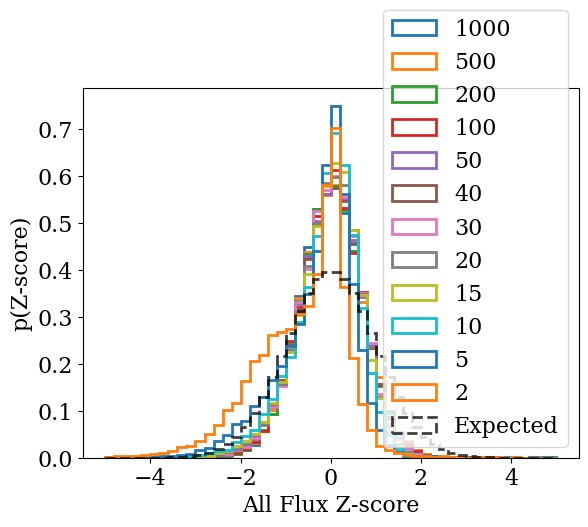

/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_45820/1004405675.py:33: RuntimeWarning: invalid value encountered in sqrt
  plt.hist(np.sqrt(np.ravel(all_f_max_chi2s)),


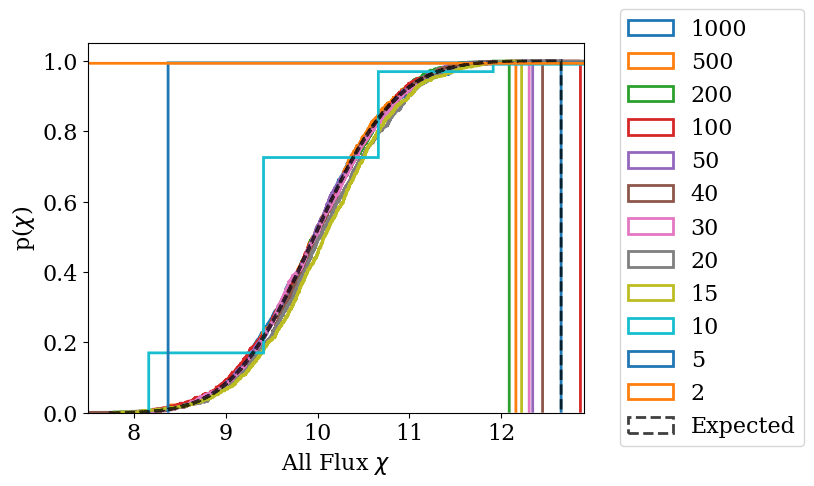

In [50]:

for flux_level_ind,flux_level in enumerate(results_dict):
    all_f_max_zscores = results_dict[flux_level]['all_f_max_zscores']
    hist = plt.hist(np.ravel(all_f_max_zscores),
                    histtype='step',cumulative=False,
                    density=True,bins=50,range=[-5,5],
                    label=flux_level,lw=lw,alpha=alpha)

hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
expect_weights = np.diff(stats.norm(loc=0,scale=1).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=False,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc='best')
plt.xlabel(r'All Flux Z-score')
plt.ylabel(r'p(Z-score)')
plt.show()


for flux_level_ind,flux_level in enumerate(results_dict):
    all_f_max_chi2s = results_dict[flux_level]['all_f_max_chi2s']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_f_max_chi2s)),
                        histtype='step',cumulative=cumulative,
                        density=True,bins=np.size(all_f_max_chi2s),
                        label=flux_level,lw=lw,alpha=alpha)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_f_max_chi2s)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_f_max_chi2s)*100,
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=flux_level,lw=lw,alpha=alpha)
plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_pixels).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.xlabel(r'All Flux $\chi$')
plt.ylabel(r'p($\chi$)')
plt.show()



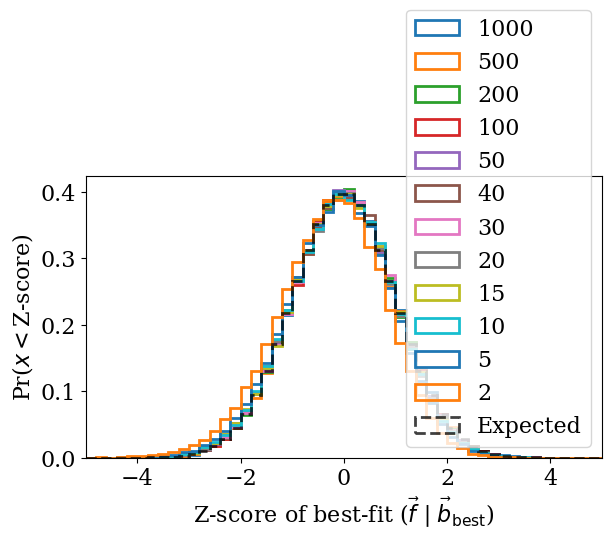

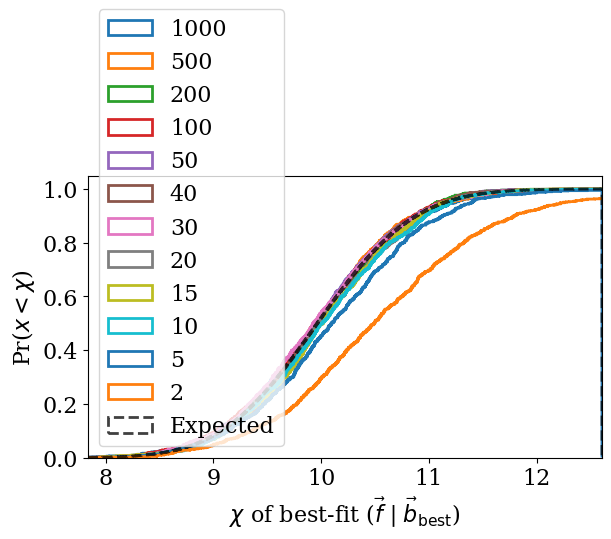

In [51]:

xlim = [-5,5]
for flux_level_ind,flux_level in enumerate(results_dict):
    all_f_given_b_zscores = results_dict[flux_level]['all_f_given_b_zscores_with_bs']
    hist = plt.hist(np.ravel(all_f_given_b_zscores),
                    histtype='step',cumulative=False,
                    density=True,bins=50,range=xlim,
                    label=flux_level,lw=lw,alpha=alpha)

hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
expect_weights = np.diff(stats.norm(loc=0,scale=1).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,
         cumulative=False,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
leg = plt.legend(loc='best')
plt.xlabel(r'Z-score of best-fit ($\vec f \mid \vec b_{\mathrm{best}}$)')
plt.ylabel(r'Pr($x < $Z-score)')
plt.xlim(xlim)
plt.tight_layout()
plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_zscore.png')
plt.show()


for flux_level_ind,flux_level in enumerate(results_dict):
    all_f_given_b_chi2s = results_dict[flux_level]['all_f_given_b_chi2s_with_bs']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_f_given_b_chi2s)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_f_given_b_chi2s),
                        label=flux_level,lw=lw,alpha=alpha)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
        xlim = hist_bins[0],hist_bins[-1]
    else:
        curr_hist_bin_min = min(np.nanmin(all_f_given_b_chi2s),hist_bins[0])
        curr_hist_bin_max = max(min(np.nanmax(all_f_given_b_chi2s),10*hist_bins[-1]),hist_bins[-1])
        curr_hist_bins = np.linspace(curr_hist_bin_min,curr_hist_bin_max,np.size(all_f_given_b_chi2s)*100)
        plt.hist(np.sqrt(np.ravel(all_f_given_b_chi2s)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=curr_hist_bins,
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=flux_level,lw=lw,alpha=alpha)
plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_pixels).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
leg = plt.legend(loc='best')
plt.xlabel(r'$\chi$ of best-fit ($\vec f \mid \vec b_{\mathrm{best}}$)')
plt.ylabel(r'Pr($x < \chi$)')
plt.tight_layout()
plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_chi.png')
plt.show()

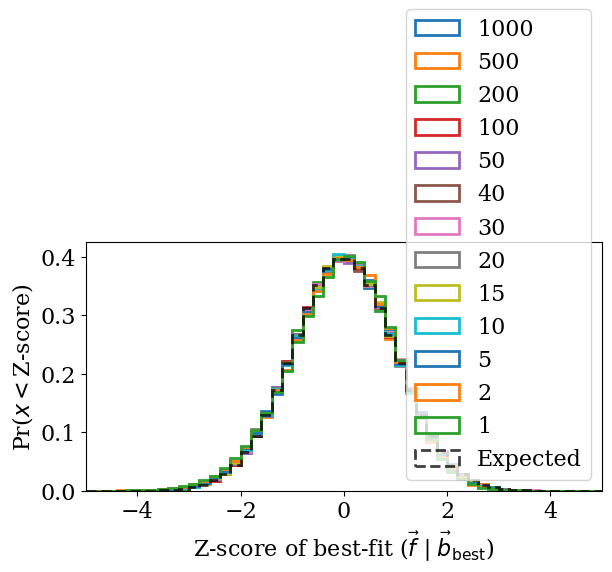

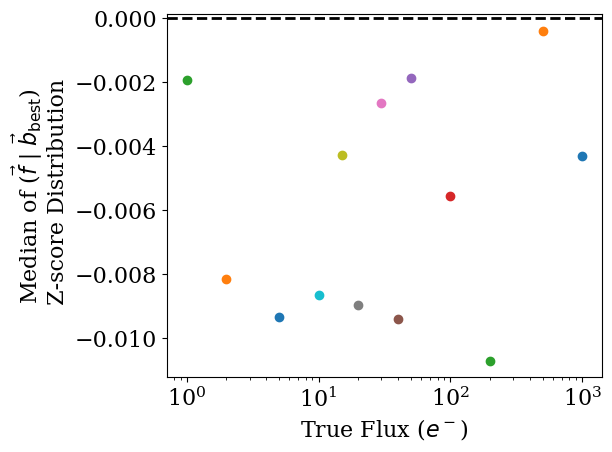

In [52]:

xlim = [-5,5]
# xlim = [-50,50]
for flux_level_ind,flux_level in enumerate(time_indep_results_dict):
    # all_f_given_b_zscores = time_indep_results_dict[flux_level]['all_f_given_b_zscores_with_bs']
    # hist = plt.hist(np.ravel(all_f_given_b_zscores),
    #                 histtype='step',cumulative=False,
    #                 density=True,bins=50,range=xlim,
    #                 label=flux_level,lw=lw,alpha=alpha)
    all_f_given_b_zscores = time_indep_results_dict[flux_level]['all_f_given_b_zscores_no_bs']
    hist = plt.hist(np.ravel(all_f_given_b_zscores),
                    histtype='step',cumulative=False,
                    density=True,bins=50,range=xlim,
                    label=flux_level,lw=lw,alpha=alpha)

hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
expect_weights = np.diff(stats.norm(loc=0,scale=1).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,
         cumulative=False,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
leg = plt.legend(loc='best')
plt.xlabel(r'Z-score of best-fit ($\vec f \mid \vec b_{\mathrm{best}}$)')
plt.ylabel(r'Pr($x < $Z-score)')
plt.xlim(xlim)
plt.tight_layout()
# plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_zscore.png')
plt.show()

plt.figure()
plt.gca().set_xscale('log')
for flux_level_ind,flux_level in enumerate(time_indep_results_dict):
    # all_f_given_b_zscores = time_indep_results_dict[flux_level]['all_f_given_b_zscores_with_bs']
    # hist = plt.hist(np.ravel(all_f_given_b_zscores),
    #                 histtype='step',cumulative=False,
    #                 density=True,bins=50,range=xlim,
    #                 label=flux_level,lw=lw,alpha=alpha)
    all_f_given_b_zscores = time_indep_results_dict[flux_level]['all_f_given_b_zscores_no_bs']
    summary = np.nanpercentile(all_f_given_b_zscores,[16,50,84])
    plt.scatter(flux_level,summary[1])
    # summary = np.nanmean(np.nanmean(all_f_given_b_zscores,axis=1))
    # plt.scatter(flux_level,summary)

plt.axhline(0,c='k',lw=2,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc='best')
plt.ylabel(r'Median of ($\vec f \mid \vec b_{\mathrm{best}}$)'+'\n Z-score Distribution')
plt.xlabel(r'True Flux ($e^-$)')
plt.tight_layout()
# plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_zscore.png')
plt.show()


# for flux_level_ind,flux_level in enumerate(time_indep_results_dict):
#     # all_f_given_b_chi2s = time_indep_results_dict[flux_level]['all_f_given_b_chi2s_with_bs']
#     all_f_given_b_zscores = time_indep_results_dict[flux_level]['all_f_given_b_chi2s_no_bs']
#     if flux_level_ind == 0:
#         hist = plt.hist(np.sqrt(np.ravel(all_f_given_b_chi2s)),
#                         histtype='step',cumulative=cumulative,
#                         density=cumulative,bins=np.size(all_f_given_b_chi2s),
#                         label=flux_level,lw=lw,alpha=alpha)

#         hist_bins = hist[1]
#         hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
#         # xlim = plt.xlim()
#         xlim = hist_bins[0],hist_bins[-1]
#     else:
#         curr_hist_bin_min = min(np.nanmin(all_f_given_b_chi2s),hist_bins[0])
#         curr_hist_bin_max = max(min(np.nanmax(all_f_given_b_chi2s),10*hist_bins[-1]),hist_bins[-1])
#         curr_hist_bins = np.linspace(curr_hist_bin_min,curr_hist_bin_max,np.size(all_f_given_b_chi2s)*100)
#         plt.hist(np.sqrt(np.ravel(all_f_given_b_chi2s)),
#                                 histtype='step',cumulative=cumulative,
#                                 density=True,bins=curr_hist_bins,
#                                 # range=[hist_bins[0],hist_bins[-1]],
#                                 label=flux_level,lw=lw,alpha=alpha)
# plt.xlim(xlim)
# expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_pixels).cdf(hist_bins))
# expect_weights /= np.sum(expect_weights)
# plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
#          density=True,bins=hist_bins,cumulative=cumulative,color='k',
#         label='Expected',lw=lw,alpha=0.75,ls='--')
# # leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc='best')
# plt.xlabel(r'$\chi$ of best-fit ($\vec f \mid \vec b_{\mathrm{best}}$)')
# plt.ylabel(r'Pr($x < \chi$)')
# plt.tight_layout()
# # plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_chi.png')
# plt.show()

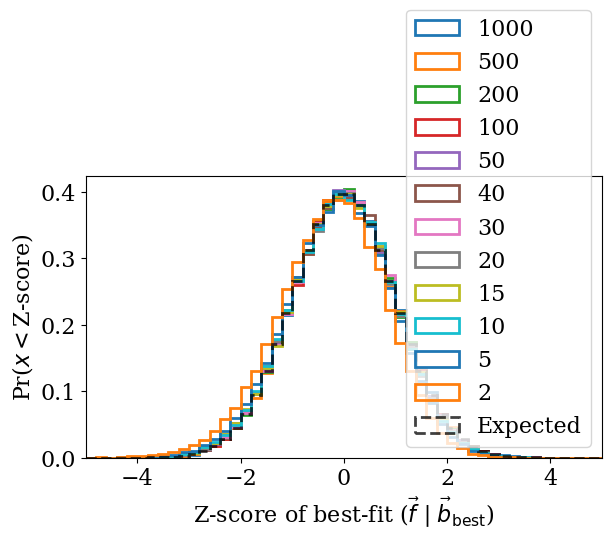

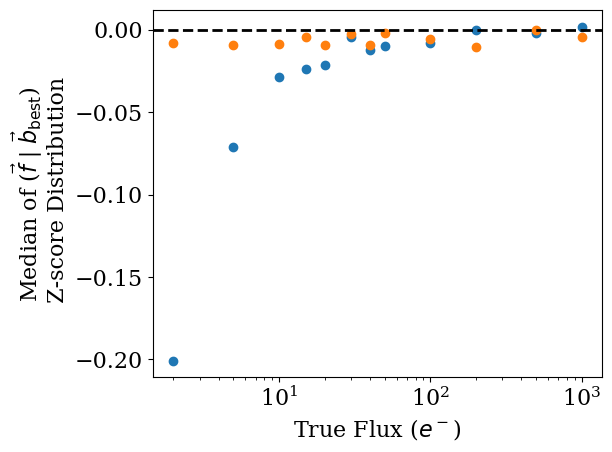

In [53]:

xlim = [-5,5]
# xlim = [-50,50]
for flux_level_ind,flux_level in enumerate(results_dict):
    all_f_given_b_zscores = results_dict[flux_level]['all_f_given_b_zscores_with_bs']
    hist = plt.hist(np.ravel(all_f_given_b_zscores),
                    histtype='step',cumulative=False,
                    density=True,bins=50,range=xlim,
                    label=flux_level,lw=lw,alpha=alpha)
    # all_f_given_b_zscores = results_dict[flux_level]['all_f_given_b_zscores_no_bs']
    # hist = plt.hist(np.ravel(all_f_given_b_zscores),
    #                 histtype='step',cumulative=False,
    #                 density=True,bins=50,range=xlim,
    #                 label=flux_level,lw=lw,alpha=alpha)

hist_bins = hist[1]
hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
expect_weights = np.diff(stats.norm(loc=0,scale=1).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,
         cumulative=False,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
leg = plt.legend(loc='best')
plt.xlabel(r'Z-score of best-fit ($\vec f \mid \vec b_{\mathrm{best}}$)')
plt.ylabel(r'Pr($x < $Z-score)')
plt.xlim(xlim)
plt.tight_layout()
plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_zscore.png')
plt.show()

plt.figure()
plt.gca().set_xscale('log')
for flux_level_ind,flux_level in enumerate(results_dict):
    all_f_given_b_zscores = np.copy(results_dict[flux_level]['all_f_given_b_zscores_with_bs'])
    keep = np.abs(all_f_given_b_zscores) < 10
    all_f_given_b_zscores[~keep] = np.nan
    summary = np.nanpercentile(all_f_given_b_zscores[keep],[16,50,84])
    plt.scatter(flux_level,summary[1],color='C0')    
    # summary = np.nanmean(np.nanmean(all_f_given_b_zscores,axis=1))
    # plt.scatter(flux_level,summary,color='C0')

for flux_level_ind,flux_level in enumerate(results_dict):
    all_f_given_b_zscores = np.copy(time_indep_results_dict[flux_level]['all_f_given_b_zscores_no_bs'])
    keep = np.abs(all_f_given_b_zscores) < 10
    all_f_given_b_zscores[~keep] = np.nan
    summary = np.nanpercentile(all_f_given_b_zscores[keep],[16,50,84])
    plt.scatter(flux_level,summary[1],color='C1')
    
    # summary = np.nanmean(np.nanmean(all_f_given_b_zscores,axis=1))
    # plt.scatter(flux_level,summary,color='C1')


plt.axhline(0,c='k',lw=2,ls='--')
# leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc='best')
plt.ylabel(r'Median of ($\vec f \mid \vec b_{\mathrm{best}}$)'+'\n Z-score Distribution')
plt.xlabel(r'True Flux ($e^-$)')
plt.tight_layout()
# plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_zscore.png')
plt.show()


# for flux_level_ind,flux_level in enumerate(results_dict):
#     all_f_given_b_chi2s = results_dict[flux_level]['all_f_given_b_chi2s_with_bs']
#     if flux_level_ind == 0:
#         hist = plt.hist(np.sqrt(np.ravel(all_f_given_b_chi2s)),
#                         histtype='step',cumulative=cumulative,
#                         density=cumulative,bins=np.size(all_f_given_b_chi2s),
#                         label=flux_level,lw=lw,alpha=alpha)

#         hist_bins = hist[1]
#         hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
#         # xlim = plt.xlim()
#         xlim = hist_bins[0],hist_bins[-1]
#     else:
#         curr_hist_bin_min = min(np.nanmin(all_f_given_b_chi2s),hist_bins[0])
#         curr_hist_bin_max = max(min(np.nanmax(all_f_given_b_chi2s),10*hist_bins[-1]),hist_bins[-1])
#         curr_hist_bins = np.linspace(curr_hist_bin_min,curr_hist_bin_max,np.size(all_f_given_b_chi2s)*100)
#         plt.hist(np.sqrt(np.ravel(all_f_given_b_chi2s)),
#                                 histtype='step',cumulative=cumulative,
#                                 density=True,bins=curr_hist_bins,
#                                 # range=[hist_bins[0],hist_bins[-1]],
#                                 label=flux_level,lw=lw,alpha=alpha)
# plt.xlim(xlim)
# expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_pixels).cdf(hist_bins))
# expect_weights /= np.sum(expect_weights)
# plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
#          density=True,bins=hist_bins,cumulative=cumulative,color='k',
#         label='Expected',lw=lw,alpha=0.75,ls='--')
# # leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
# leg = plt.legend(loc='best')
# plt.xlabel(r'$\chi$ of best-fit ($\vec f \mid \vec b_{\mathrm{best}}$)')
# plt.ylabel(r'Pr($x < \chi$)')
# plt.tight_layout()
# plt.savefig(f'{plotpath}repeat_fit_f_given_bvect_chi.png')
# plt.show()

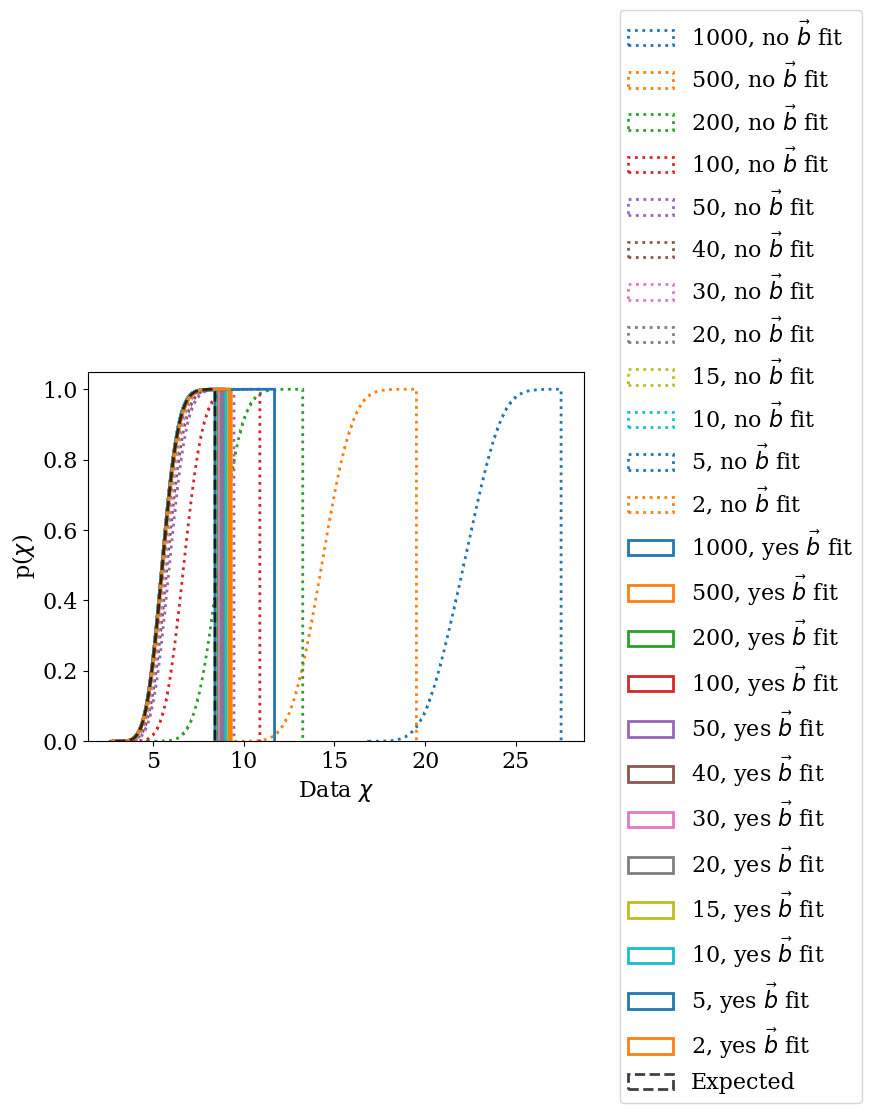

In [54]:

for flux_level_ind,flux_level in enumerate(results_dict):
    color = 'C%d'%flux_level_ind
    ls = ':'
    label = f'{flux_level}, '+r'no $\vec b$ fit'
    all_chi2s_data_no_bs = results_dict[flux_level]['all_chi2s_data_no_bs']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_chi2s_data_no_bs)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_chi2s_data_no_bs),
                        label=label,lw=lw,alpha=alpha,color=color,ls=ls)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_chi2s_data_no_bs)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_chi2s_data_no_bs),
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=label,lw=lw,alpha=alpha,color=color,ls=ls)
        
for flux_level_ind,flux_level in enumerate(results_dict):
    color = 'C%d'%flux_level_ind
    ls = '-'
    label = f'{flux_level}, '+r'yes $\vec b$ fit'
    all_chi2s_data_with_bs = results_dict[flux_level]['all_chi2s_data_with_bs']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_chi2s_data_with_bs)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_chi2s_data_with_bs),
                        label=label,lw=lw,alpha=alpha,color=color,ls=ls)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_chi2s_data_with_bs)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_chi2s_data_with_bs),
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=label,lw=lw,alpha=alpha,color=color,ls=ls)


# plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.xlabel(r'Data $\chi$')
plt.ylabel(r'p($\chi$)')
plt.show()


KeyboardInterrupt: 

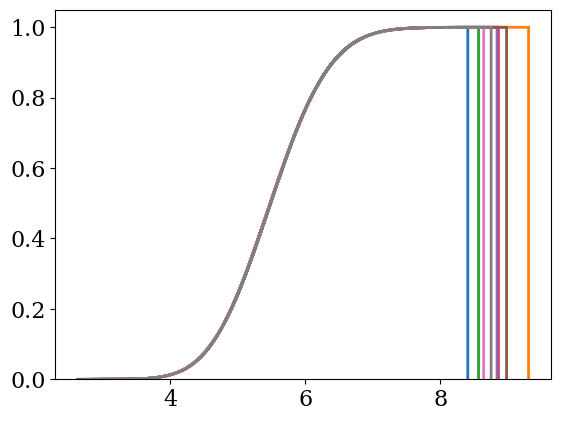

In [55]:
for flux_level_ind,flux_level in enumerate(results_dict):
    color = 'C%d'%flux_level_ind
    ls = '-'
    label = f'{flux_level}, '+r'yes $\vec b$ fit'
    all_chi2s_data_with_bs = results_dict[flux_level]['all_chi2s_data_with_bs']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_chi2s_data_with_bs)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_chi2s_data_with_bs),
                        label=label,lw=lw,alpha=alpha,color=color,ls=ls)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_chi2s_data_with_bs)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_chi2s_data_with_bs)*100,
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=label,lw=lw,alpha=alpha,color=color,ls=ls)


# plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.xlabel(r'Data $\chi$')
plt.ylabel(r'p($\chi$)')
plt.show()


In [ ]:

for flux_level_ind,flux_level in enumerate(results_dict):
    color = 'C%d'%flux_level_ind
    ls = ':'
    label = f'{flux_level}, '+r'no $\vec b$ fit'
    all_low_flux_chi2s_data_no_bs = results_dict[flux_level]['all_low_flux_chi2s_data_no_bs']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_low_flux_chi2s_data_no_bs)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_low_flux_chi2s_data_no_bs),
                        label=label,lw=lw,alpha=alpha,color=color,ls=ls)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_low_flux_chi2s_data_no_bs)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_low_flux_chi2s_data_no_bs)*100,
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=label,lw=lw,alpha=alpha,color=color,ls=ls)
        
for flux_level_ind,flux_level in enumerate(results_dict):
    color = 'C%d'%flux_level_ind
    ls = '-'
    label = f'{flux_level}, '+r'yes $\vec b$ fit'
    all_low_flux_chi2s_data_with_bs = results_dict[flux_level]['all_low_flux_chi2s_data_with_bs']
    if flux_level_ind == 0:
        hist = plt.hist(np.sqrt(np.ravel(all_low_flux_chi2s_data_with_bs)),
                        histtype='step',cumulative=cumulative,
                        density=cumulative,bins=np.size(all_low_flux_chi2s_data_with_bs),
                        label=label,lw=lw,alpha=alpha,color=color,ls=ls)

        hist_bins = hist[1]
        hist_bin_centers = 0.5*(hist_bins[1:]+hist_bins[:-1])
        # xlim = plt.xlim()
    else:
        plt.hist(np.sqrt(np.ravel(all_low_flux_chi2s_data_with_bs)),
                                histtype='step',cumulative=cumulative,
                                density=True,bins=np.size(all_low_flux_chi2s_data_with_bs)*100,
                                # range=[hist_bins[0],hist_bins[-1]],
                                label=label,lw=lw,alpha=alpha,color=color,ls=ls)


# plt.xlim(xlim)
expect_weights = np.diff(stats.chi(loc=0,scale=1,df=n_reads-2).cdf(hist_bins))
expect_weights /= np.sum(expect_weights)
plt.hist(hist_bin_centers,weights=expect_weights,histtype='step',
         density=True,bins=hist_bins,cumulative=cumulative,color='k',
        label='Expected',lw=lw,alpha=0.75,ls='--')
leg = plt.legend(loc=6,bbox_to_anchor=(1.05,0.5))
plt.xlabel(r'Low Flux Data $\chi$')
plt.ylabel(r'p($\chi$)')
plt.show()
